In [3]:
%matplotlib inline

import os
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../../Code/')
from utils import read_dataset_log
#from adjustText import adjust_text

from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from scipy.stats import spearmanr, pearsonr
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection


def test_association_unpaired(_meta, _usage, _pheno_col, _idv_col, cat_covar_cols=[], quant_covar_cols=[], _min_cell_thresh=None, method='OLS'):
    if ((len(cat_covar_cols) > 0) or (len(quant_covar_cols) > 0)) and (method != 'OLS'):
        raise Exception('Only provide covariates with OLS association test')
        
    if method not in ['OLS', 'Ttest']:
        raise Exception('Method %s not found. Please use OLS or Ttest' % method)
        
    ct = pd.crosstab(_meta[_idv_col], _meta[_pheno_col])
    if (ct>0).sum(axis=1).max()>1:
        raise Exception('Samples not mutually exclusive with phenotype. Please use paired association test instead')
    
    numcells = ct.max(axis=1)
    samples_to_filt = numcells.index[numcells<_min_cell_thresh]
    ind = ~_meta[_idv_col].isin(samples_to_filt) & ~_meta[_pheno_col].isnull()
    _meta_filt = _meta.loc[ind, [_pheno_col, _idv_col]]
    _meta_filt[_idv_col] = _meta_filt[_idv_col].astype(str)
    _usage_filt = _usage.loc[ind, :]    
        
    _output_geps = _usage_filt.groupby(_meta_filt[_idv_col]).mean()    
        
    pheno_results = []
    covar_results = []
    if method == 'OLS':
        if (len(cat_covar_cols)>0):
            _covar_filt = []
            for i,c in enumerate(cat_covar_cols):
                dummies = pd.get_dummies(_meta.loc[ind,c])
                if i > 0:
                    last_col = dummies.columns[-1]    
                else:
                    last_col = []
                _covar_filt.append(dummies.drop(last_col, axis=1))
                
            _covar_filt = pd.concat(_covar_filt, axis=1) 
            _meta_filt = pd.concat([_meta_filt,_covar_filt], axis=1)

            
        if len(quant_covar_cols) > 0:
            for c in quant_covar_cols:
                _meta_filt[c] =  meta.loc[ind,c]
                
        # Get average phenotype, usage, and covariate score per sample
        _predictors = _meta_filt.groupby(_idv_col).mean()
        if len(cat_covar_cols)==0:
            _predictors['Intercept'] = 1
    
        # Run association
        for gep in _output_geps.columns:
            mod = sm.OLS(_output_geps[gep], _predictors)
            res = mod.fit(cov_type='HC1')                
                
            m1 = _output_geps.loc[_predictors[_pheno_col]==1, gep].mean()
            m0 = _output_geps.loc[_predictors[_pheno_col]==0, gep].mean()
            pheno_results.append([gep, res.pvalues[_pheno_col], res.params[_pheno_col], m0, m1])
            covar_results.append([gep] + list(res.pvalues.drop(_pheno_col)) + list(res.params.drop(_pheno_col)))
            
        covar_results = pd.DataFrame(covar_results)
        covar_results.columns = ['GEP'] + ['P_%s' % x for x in res.pvalues.drop(_pheno_col).index] + ['B_%s' % x for x in res.params.drop(_pheno_col).index]
        covar_results.index = covar_results['GEP']
        covar_results.drop('GEP', axis=1, inplace=True)
            
            
    elif method == 'Ttest':
        _predictors = _meta_filt.groupby(_idv_col).mean()
        for gep in _output_geps.columns:
            ind = _predictors[_pheno_col]==1
            t_stat, p_val = ttest_ind(_output_geps.loc[ind, gep], _output_geps.loc[~ind, gep], equal_var = False)
            m1 = _output_geps.loc[ind, gep].mean()
            m0 = _output_geps.loc[~ind, gep].mean()
            pheno_results.append([gep, p_val, t_stat, m0, m1])
        
    pheno_results = pd.DataFrame(pheno_results, columns=['GEP', 'P', 'Beta', 'M0', 'M1'])
    pheno_results.index = pheno_results['GEP']
    pheno_results.drop('GEP', axis=1, inplace=True)
    pheno_results['FC'] = pheno_results['M1'] / pheno_results['M0']
    pheno_results['log2_FC'] = pheno_results['FC'].apply(np.log2)
    _, pheno_results['Q'] = fdrcorrection(pheno_results['P'])
    pheno_results['Pheno'] = p 
    pheno_results['logP'] = pheno_results['P'].apply(np.log10)*-1 
    pheno_results['logQ'] = pheno_results['Q'].apply(np.log10)*-1
    
    sample_level_data = pd.concat([_predictors, _output_geps], axis=1)
    
    
    return(pheno_results, covar_results, sample_level_data)


In [4]:
from matplotlib import rcParams, font_manager

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
#rcParams['text.usetex'] = True


In [5]:
figdir = '../../Figures/Components'

In [6]:
min_cells = 10

In [7]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params = params[params['dataset_type']=='discovery']
params

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,tcat_fn_withsingletons,manual_gating_fn,manual_activation_gating_fn,activation_score_fn,metadata_fn,...,cnmf_dir,k,dt,processed_forcnmf_fn,tpm_counts_for_cnmf_fn,raw_counts_filt_fn,raw_counts_fn,dataset_type,tissue_type,context_label
dataset,,,,,,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Activa...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,...,/data/srlab1/TCAT/Data/PerDataset/AMPRA,34.0,0_15,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,discovery,Synovium,RA+OA
Pan-Cancer,Pan-Cancer,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Ac...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,...,/data/srlab1/TCAT/Data/PerDataset/Pancancer,38.0,0.15,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,discovery,Pan-Tissue,Cancer+Healthy
TBRU,TBRU,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...,/data/srlab1/TCAT/Data/PerDataset/TBRU/Activat...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,...,/data/srlab1/TCAT/Data/PerDataset/TBRU,36.0,0_20,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,discovery,Blood,Healthy
HIV-Vaccine,HIV-Vaccine,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Acti...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl,31.0,0_15,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,discovery,Blood,Post-Vaccine+Healthy
UK-Covid,UK-Covid,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Acti...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID,44.0,0_20,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,discovery,Blood,Covid-19+Healthy
COMBAT,COMBAT,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data

In [8]:
cgep_info = read_dataset_log('cGEP_Name')
cgep_info.index = cgep_info['cGep_Name']
cgep_info.head()

,cGep_Name,Old_Short_Name,Long_Name,Short_Name,Shortest_Name,Class,Num_Datasets,Notes,Reviewed,Filter
cGep_Name,,,,,,,,,,
COMBAT_Cytoskeleton,COMBAT_Cytoskeleton,Cytoskeleton,Actin Cytoskeleton,Cytoskeleton,Cytosk.,Functional,7.0,NaN,Y,NaN
CD8_EM,CD8_EM,CD8-EM,CD8 Effector Memory,CD8-EM,CD8-EM,Lineage,7.0,Need to confirm overlap with gating since the ...,Y,NaN
CellCycle-G2M,CellCycle-G2M,CellCycle-G2M,Cell Cycle G2M Phase,CellCycle-G2M,G2M-phase,Functional,7.0,NaN,Y,NaN
CellCycle-S,CellCycle-S,CellCycle-S,Cell Cycle S Phase,CellCycle-S,S-phase,Functional,7.0,NaN,Y,NaN
Cytotoxic,Cytotoxic,Cytotoxic,Cytotoxic,Cytotoxic,Cytotoxic,Functional,7.0,NaN,Y,NaN


In [9]:
rename_map = dict(zip(cgep_info['cGep_Name'], cgep_info['Short_Name']))

In [10]:
shorten_map = dict(zip(cgep_info['Short_Name'], cgep_info['Shortest_Name']))

In [11]:
all_results = {}
sample_data = {}
allmeta = {}

# COMBAT

In [12]:
dataset = 'COMBAT'
all_results[dataset] = {}
sample_data[dataset] = {}
sample_col = params.loc[dataset, 'sample_col']
individual_col = params.loc[dataset, 'individual_col']
usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t').rename(columns=rename_map)
usage = usage.div(usage.sum(axis=1), axis=0)
meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], sep = '\t', index_col = 0)
meta = meta.loc[usage.index, :]
gating = pd.read_csv(params.loc[dataset,'manual_gating_fn'], sep='\t', index_col=0)['0']
meta['Gating'] = gating.loc[meta.index]

In [13]:
sample_col

'COMBAT_participant_timepoint_ID'

In [14]:
meta[[individual_col, 'Source']].drop_duplicates()['Source'].value_counts()

COVID_SEV         32
Sepsis            23
COVID_CRIT        18
COVID_MILD        17
COVID_HCW_MILD    12
Flu               12
HV                10
COVID_LDN          2
Name: Source, dtype: int64

In [15]:
## For individuals with multiple samples, filter the sample with fewer cells
ct = pd.crosstab(meta[individual_col], meta[sample_col])
display((ct>0).sum(axis=1).value_counts())
ind = (ct>0).sum(axis=1)>1
ct = ct.loc[ind, :]
tokeep = ct.loc[:, (ct>0).sum(axis=0)>0].idxmax(axis=1)
tofilt = meta[individual_col].isin(tokeep.index) & ~meta[sample_col].isin(tokeep.values)
meta = meta.loc[~tofilt, :]
usage = usage.loc[~tofilt, :]
allmeta[dataset] = meta

ct = pd.crosstab(meta[individual_col], meta[sample_col])
(ct>0).sum(axis=1).value_counts()

1    109
2     10
3      3
dtype: int64

1    122
dtype: int64

In [16]:
meta[[individual_col, 'Source']].drop_duplicates()['Source'].value_counts()

COVID_SEV         29
Sepsis            23
COVID_MILD        17
COVID_CRIT        17
COVID_HCW_MILD    12
Flu               12
HV                10
COVID_LDN          2
Name: Source, dtype: int64

In [17]:
mapping = {'COVID_SEV':1, 'Sepsis':np.nan, 'COVID_MILD':1, 'COVID_HCW_MILD':1, 'HV':0,
       'COVID_CRIT':1, 'COVID_LDN':1, 'Flu':np.nan}

meta['COVID_vs_Healthy'] = meta['Source'].replace(mapping)

mapping = {'COVID_SEV':0, 'Sepsis':np.nan, 'COVID_MILD':0, 'COVID_HCW_MILD':0, 'HV':np.nan,
       'COVID_CRIT':1, 'COVID_LDN':1, 'Flu':np.nan}
meta['COVID_Severe_vs_Mild'] = meta['Source'].replace(mapping)


#meta['COVID_Severe_vs_Mild'] = np.nan
#ind = meta['COVID_vs_Healthy']==1
#{1:'Death', 2:'Intubated', 3:'NiV', 4:'O2', 5:'No O2', 6:'Not hospitalized'}
#meta.loc[ind, 'COVID_Severe_vs_Mild'] = meta.loc[ind, 'Outcome'].replace({1:1, 2:1, 3:0, 4:0, 5:0, 6:0})


In [18]:
 meta[['Source', individual_col]].drop_duplicates()['Source'].value_counts()

COVID_SEV         29
Sepsis            23
COVID_MILD        17
COVID_CRIT        17
COVID_HCW_MILD    12
Flu               12
HV                10
COVID_LDN          2
Name: Source, dtype: int64

In [19]:
pd.crosstab(meta['Source'], meta['Outcome'].replace(np.nan, 'null'))

Outcome,1.0,2.0,3.0,4.0,5.0,6.0,null
Source,,,,,,,
COVID_CRIT,5653,38724,0,0,0,0,0
COVID_HCW_MILD,0,0,0,0,0,51832,0
COVID_LDN,3513,7120,0,0,0,0,0
COVID_MILD,0,0,0,10901,47817,0,0
COVID_SEV,10119,15678,26682,27948,0,0,0
Flu,1972,5800,0,0,0,0,0
HV,0,0,0,0,0,50641,0
Sepsis,0,0,0,0,0,0,60549


In [20]:
meta['COVID_vs_Healthy'].value_counts()

1.0    245987
0.0     50641
Name: COVID_vs_Healthy, dtype: int64

In [21]:
meta['COVID_Severe_vs_Mild'].value_counts()

0.0    190977
1.0     55010
Name: COVID_Severe_vs_Mild, dtype: int64

In [22]:
meta['QC_log10_total_UMI'] = meta['QC_total_UMI'].apply(np.log10)

In [23]:
meta.columns

Index(['Annotation_cluster_name', 'Annotation_minor_subset',
       'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region',
       'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial',
       'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID',
       'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive',
       'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA',
       'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA',
       'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2',
       'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2',
       'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2',
       'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB',
       'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2',
       'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2',
       'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2',
       'TCR_umis_TRB2', 'COMBAT_ID',

In [24]:
X = pd.merge(left=meta, right=usage[['IEG', 'IEG2', 'IEG3']], left_index=True, right_index=True, how='inner')
X['IEG_Sum'] = X[['IEG', 'IEG2', 'IEG3']].sum(axis=1)

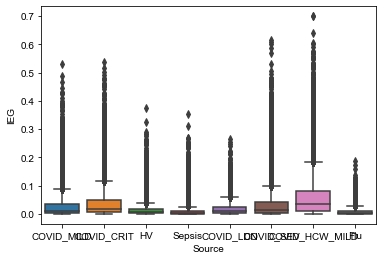

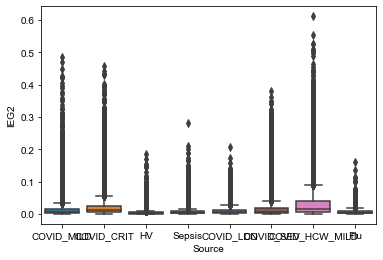

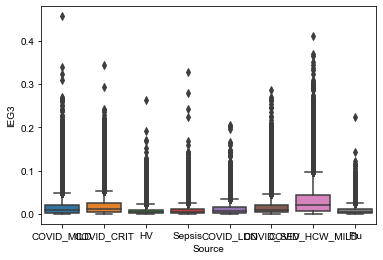

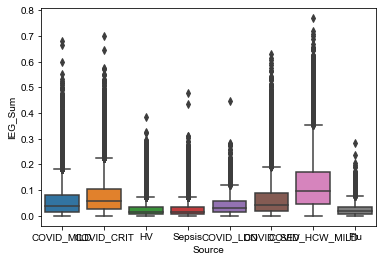

In [25]:
for i,pheno in enumerate(['Source']):
    for j,gep in enumerate(['IEG', 'IEG2', 'IEG3', 'IEG_Sum']):
        fig,ax=plt.subplots(1,1)
        sns.boxplot(x=pheno, y=gep, data=X, ax=ax)

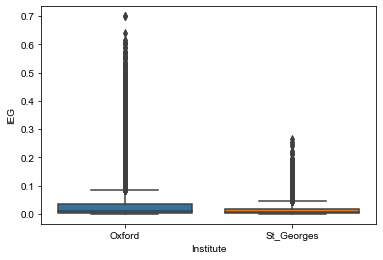

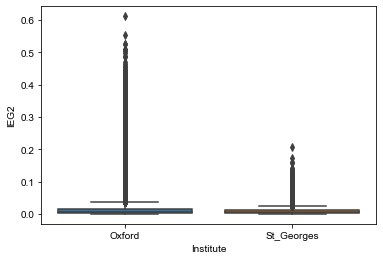

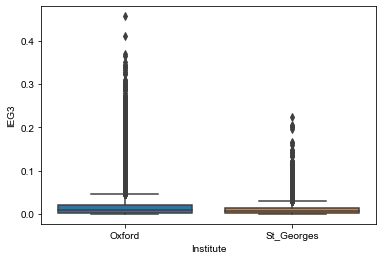

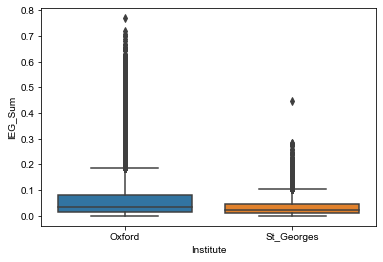

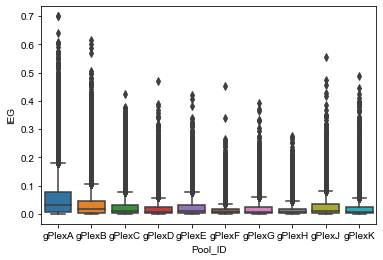

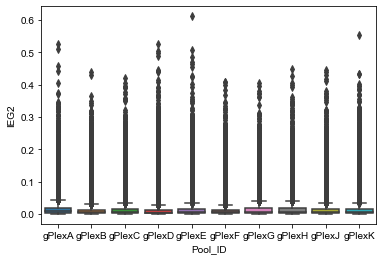

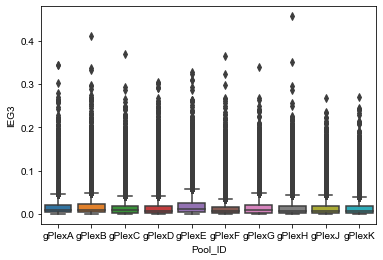

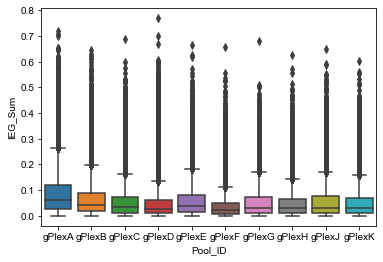

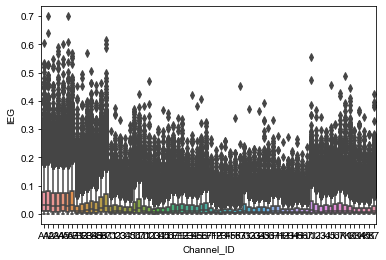

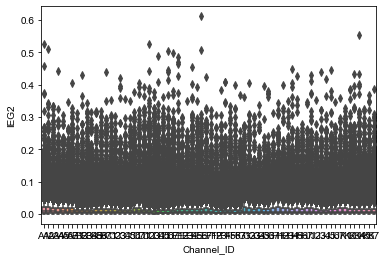

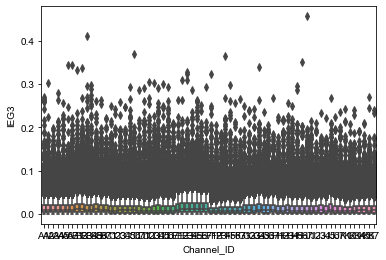

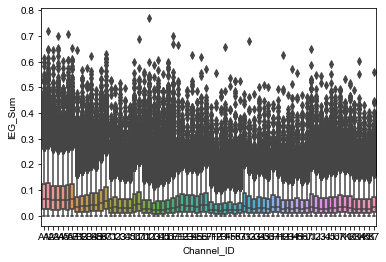

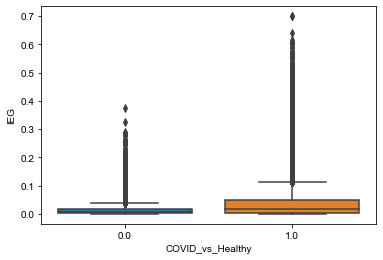

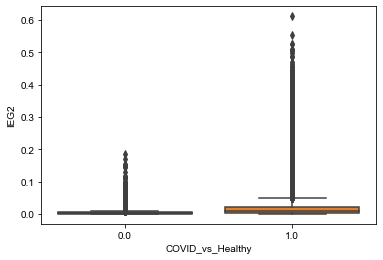

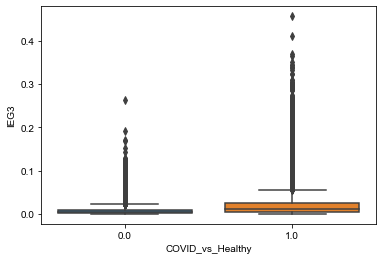

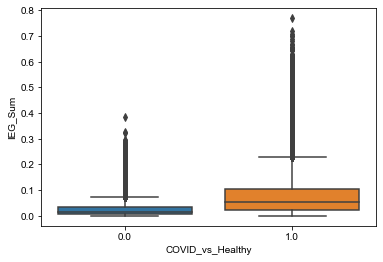

In [26]:
for i,pheno in enumerate(['Institute', 'Pool_ID', 'Channel_ID', 'COVID_vs_Healthy']):
    for j,gep in enumerate(['IEG', 'IEG2', 'IEG3', 'IEG_Sum']):
        fig,ax=plt.subplots(1,1)
        sns.boxplot(x=pheno, y=gep, data=X, ax=ax)

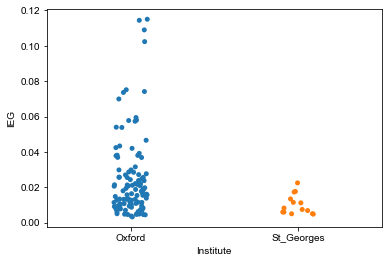

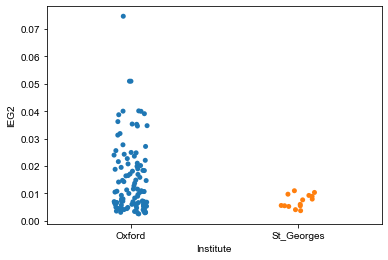

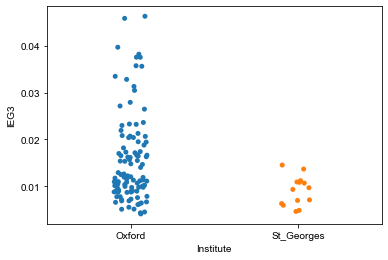

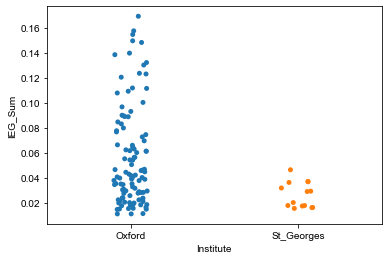

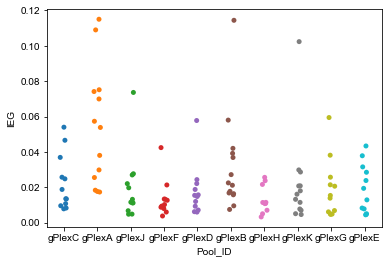

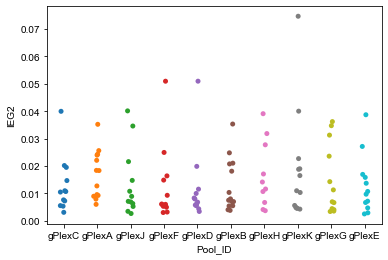

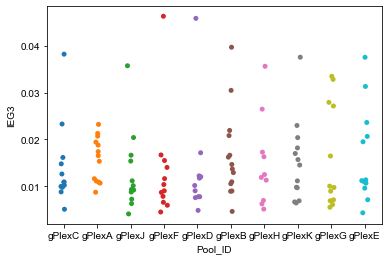

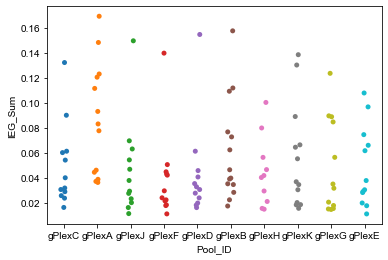

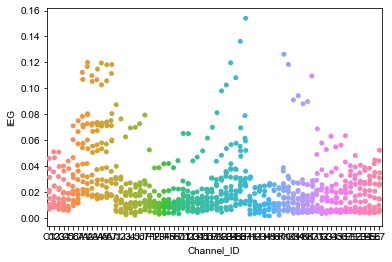

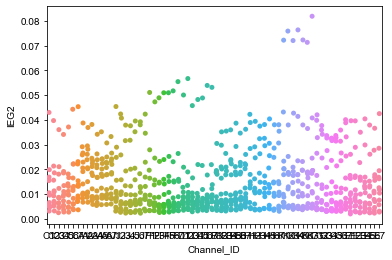

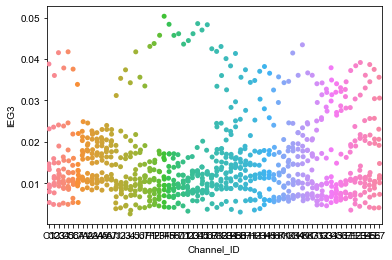

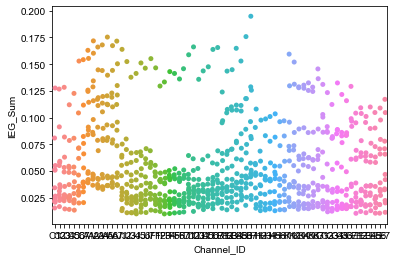

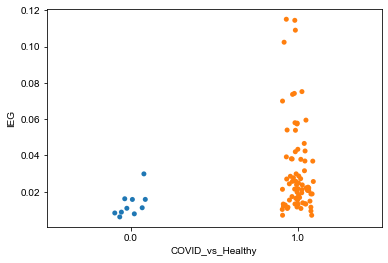

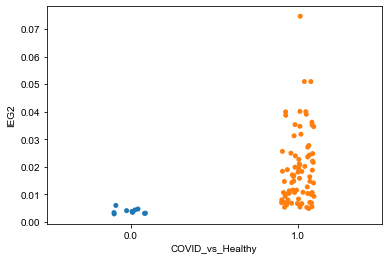

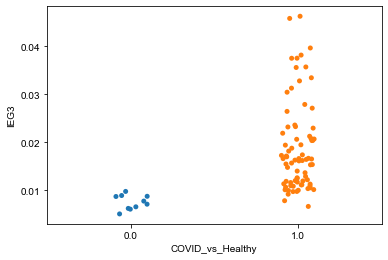

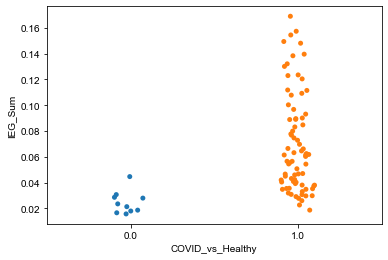

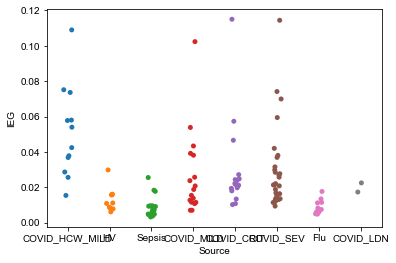

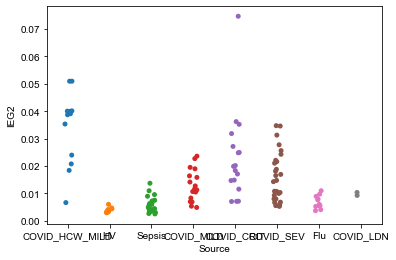

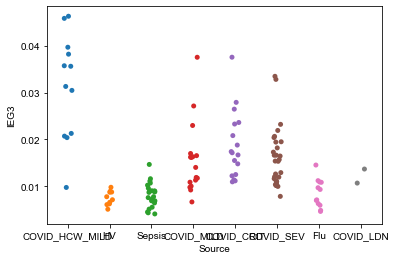

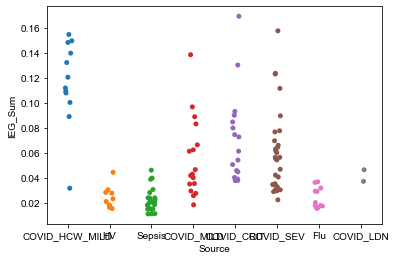

In [27]:
for i,pheno in enumerate(['Institute', 'Pool_ID', 'Channel_ID', 'COVID_vs_Healthy', 'Source']):
    for j,gep in enumerate(['IEG', 'IEG2', 'IEG3', 'IEG_Sum']):
        sub = X.groupby([sample_col, pheno])[gep].mean().reset_index()
        fig,ax=plt.subplots(1,1)
        sns.stripplot(x=pheno, y=gep, data=sub, ax=ax)

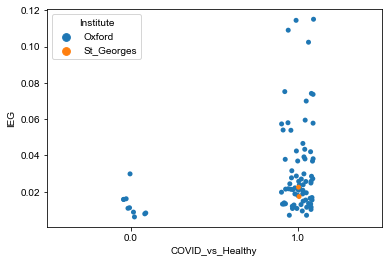

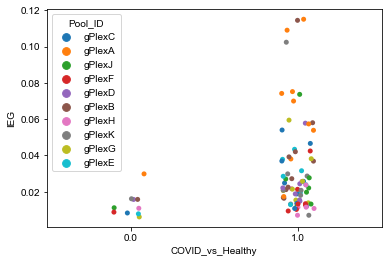

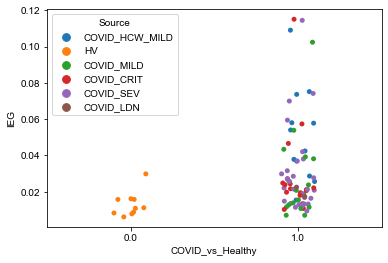

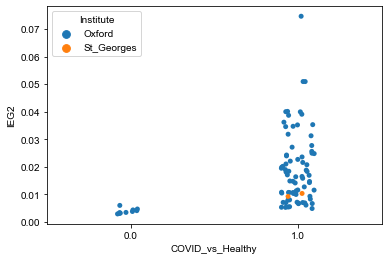

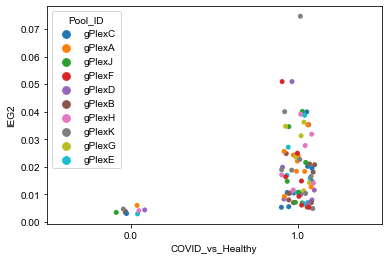

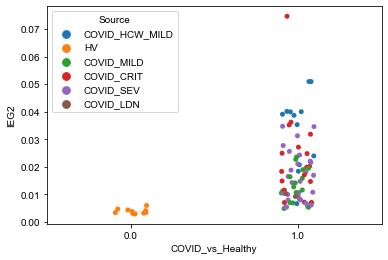

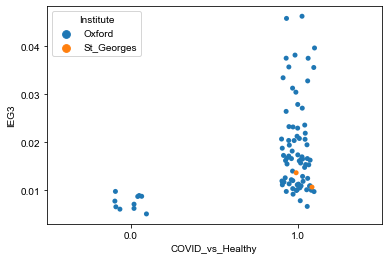

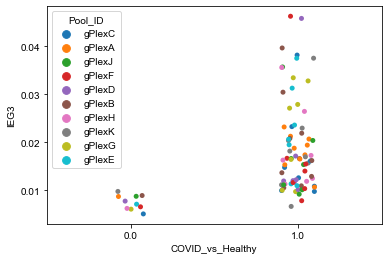

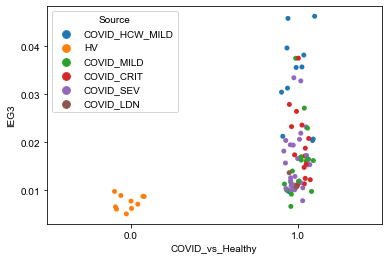

In [28]:
g = 'IEG2'
g = 'IEG3'
g = 'IEG'
for gep in ['IEG', 'IEG2', 'IEG3']:
    for hue in ['Institute', 'Pool_ID', 'Source']:
        sub = X.groupby([sample_col, 'Institute', 'Pool_ID', 'COVID_vs_Healthy', 'Source'])[gep].mean().reset_index()
        fig,ax=plt.subplots(1,1)
        sns.stripplot(x='COVID_vs_Healthy', y=gep, data=sub, ax=ax, hue=hue)

In [29]:
cat_covars = ['Pool_ID', 'Institute']
#q_covars = ['QC_total_UMI']
q_covars = []


In [30]:
res = {}
for p in ['COVID_vs_Healthy', 'COVID_Severe_vs_Mild']:
    pc, cc, sample_level = test_association_unpaired(meta, usage, p,
                                            individual_col, cat_covar_cols=cat_covars, quant_covar_cols=q_covars,
                                            _min_cell_thresh=min_cells, method='OLS')

    all_results[dataset][p] = pc
    sample_data[dataset][p] = sample_level

In [31]:
all_results[dataset]['COVID_vs_Healthy'].loc['ISG', :]

P                  0.002385
Beta               0.019481
M0                 0.010845
M1                 0.029844
FC                 2.751739
log2_FC            1.460344
Q                  0.005168
Pheno      COVID_vs_Healthy
logP               2.622491
logQ               2.286699
Name: ISG, dtype: object

# UK-Covid

In [32]:
dataset = 'UK-Covid'
all_results[dataset] = {}
sample_data[dataset] = {}
sample_col = params.loc[dataset, 'sample_col']
individual_col = params.loc[dataset, 'individual_col']
usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t').rename(columns=rename_map)
usage = usage.div(usage.sum(axis=1), axis=0)
meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], sep = '\t', index_col = 0)
#gating = pd.read_csv(params.loc[dataset,'manual_gating_fn'], sep='\t', index_col=0)['0']
#meta['Gating'] = gating.loc[meta.index]

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [33]:
## For individuals with multiple samples, filter the sample with fewer cells
ct = pd.crosstab(meta[individual_col], meta[sample_col])
display((ct>0).sum(axis=1).value_counts())
ind = (ct>0).sum(axis=1)>1
ct = ct.loc[ind, :]
tokeep = ct.loc[:, (ct>0).sum(axis=0)>0].idxmax(axis=1)
tofilt = meta[individual_col].isin(tokeep.index) & ~meta[sample_col].isin(tokeep.values)
meta = meta.loc[~tofilt, :]
usage = usage.loc[~tofilt, :]
allmeta[dataset] = meta


ct = pd.crosstab(meta[individual_col], meta[sample_col])
(ct>0).sum(axis=1).value_counts()

1    109
2     12
dtype: int64

1    121
dtype: int64

In [34]:
pcol = 'Status_on_day_collection_summary'
mapping = {'Moderate':1, 'Healthy':0, 'Severe':1, 'Mild':1, 'Critical':1, 'Asymptomatic':np.nan, 'Non_covid':np.nan, 'LPS_90mins':np.nan, 'LPS_10hours':np.nan}
meta['COVID_vs_Healthy'] = meta[pcol].map(mapping)
pd.crosstab(meta[pcol].replace(np.nan, 'null'), meta['COVID_vs_Healthy'].replace(np.nan, 'null'))

COVID_vs_Healthy,0.0,1.0,null
Status_on_day_collection_summary,,,
Asymptomatic,0,0,14152
Critical,0,31002,0
Healthy,54232,0,0
LPS_10hours,0,0,1121
LPS_90mins,0,0,1436
Mild,0,56903,0
Moderate,0,70298,0
Non_covid,0,0,8425
Severe,0,27682,0


In [35]:
pcol = 'Status_on_day_collection_summary'
mapping = {'Moderate':0, 'Healthy':np.nan, 'Severe':0, 'Mild':0, 'Critical':1, 'Asymptomatic':np.nan, 'Non_covid':np.nan, 'LPS_90mins':np.nan, 'LPS_10hours':np.nan}
meta['COVID_Severe_vs_Mild'] = meta[pcol].map(mapping)
pd.crosstab(meta[pcol].replace(np.nan, 'null'), meta['COVID_Severe_vs_Mild'].replace(np.nan, 'null'))

COVID_Severe_vs_Mild,0.0,1.0,null
Status_on_day_collection_summary,,,
Asymptomatic,0,0,14152
Critical,0,31002,0
Healthy,0,0,54232
LPS_10hours,0,0,1121
LPS_90mins,0,0,1436
Mild,56903,0,0
Moderate,70298,0,0
Non_covid,0,0,8425
Severe,27682,0,0


In [36]:
meta['log_counts'] = meta['total_counts'].apply(np.log10)

In [37]:
meta.columns

Index(['sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts',
       'total_counts_mt', 'pct_counts_mt', 'full_clustering',
       'initial_clustering', 'Resample', 'Collection_Day', 'Sex',
       'Age_interval', 'Swab_result', 'Status', 'Smoker',
       'Status_on_day_collection', 'Status_on_day_collection_summary',
       'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status',
       'Outcome', 'patient_id', 'pct_mito', 'IEG_GEP_Score', 'n_counts',
       'FOS_expr', 'JUN_expr', 'JUNB_expr', 'ZFP36_expr', 'IEG_Usage',
       'RNA_Modality_Weight', 'leiden_WNN', 'full_clustering_reduced',
       'leiden_WNN_lab', 'leiden_WNN_lab_reduced', 'leiden',
       'COVID_vs_Healthy', 'COVID_Severe_vs_Mild', 'log_counts'],
      dtype='object')

In [38]:
cat_covars = ['Site']
#q_covars = ['total_counts']
q_covars = []

In [39]:
for p in ['COVID_vs_Healthy', 'COVID_Severe_vs_Mild']:
    pc, cc, sample_level = test_association_unpaired(meta, usage, p,
                                            individual_col, cat_covar_cols=cat_covars, quant_covar_cols=q_covars,
                                            _min_cell_thresh=min_cells, method='OLS')

    all_results[dataset][p] = pc
    sample_data[dataset][p] = sample_level

In [40]:
all_results['UK-Covid']['COVID_vs_Healthy'].loc['ISG', :]

P                       0.0
Beta               0.023576
M0                 0.006783
M1                 0.034569
FC                 5.096612
log2_FC            2.349538
Q                       0.0
Pheno      COVID_vs_Healthy
logP                7.40699
logQ               6.690987
Name: ISG, dtype: object

In [41]:
all_results['UK-Covid']['COVID_vs_Healthy'].loc['ISG', 'Q']

2.0371029152050814e-07

# Covid-19 plots

In [42]:
sample_data['UK-Covid']['COVID_vs_Healthy']['COVID_vs_Healthy'].value_counts()

1.0    80
0.0    21
Name: COVID_vs_Healthy, dtype: int64

In [43]:
sample_data['COMBAT']['COVID_vs_Healthy']['COVID_vs_Healthy'].value_counts()

1.0    77
0.0    10
Name: COVID_vs_Healthy, dtype: int64

In [48]:
aim_lineage = ['Th17-Resting', 'Treg', 'Tph', 'Tfh-2', 'Th22', ]
aim_functional = ['CellCycle-G2M', 'CTLA4/CD38', 'Cytoskeleton', 'Heatshock',
       'CellCycle-S', 'ICOS/CD38', 'NME1/FABP5',
       'OX40/EBI3', 'Multi-Cytokine', 'RGCC/MYADM', 'Exhaustion',
       'CellCycle-Late-S', 'TIMD4/TIM3',
       'BCL2/FAM13A', 'HLA', 'Th2-Activated', 'Th17-Activated']
aim = aim_lineage+aim_functional

In [49]:
set(aim) - set(all_results[dataset][p].index)

set()

In [50]:
sorted(all_results[dataset][p].index)

['BCL2/FAM13A',
 'CD172a/MERTK',
 'CD4-CM',
 'CD4-Naive',
 'CD40LG/TXNIP',
 'CD8-EM',
 'CD8-Naive',
 'CD8-Trm',
 'CTLA4/CD38',
 'CellCycle-G2M',
 'CellCycle-Late-S',
 'CellCycle-S',
 'Cytoskeleton',
 'Cytotoxic',
 'Doublet-Bcell',
 'Doublet-Fibroblast',
 'Doublet-Myeloid',
 'Doublet-Plasmablast',
 'Doublet-Platelet',
 'Doublet-RBC',
 'Exhaustion',
 'HLA',
 'Heatshock',
 'ICOS/CD38',
 'IEG',
 'IEG2',
 'IEG3',
 'IL10/IL19',
 'ISG',
 'MAIT',
 'Metallothionein',
 'Mito',
 'Multi-Cytokine',
 'NME1/FABP5',
 'OX40/EBI3',
 'Poor-Quality',
 'RGCC/MYADM',
 'SOX4/TOX2',
 'TEMRA',
 'TIMD4/TIM3',
 'Tfh-1',
 'Tfh-2',
 'Th1-Like',
 'Th17-Activated',
 'Th17-Resting',
 'Th2-Activated',
 'Th2-Resting',
 'Th22',
 'Tph',
 'Translation',
 'Treg',
 'gdT']

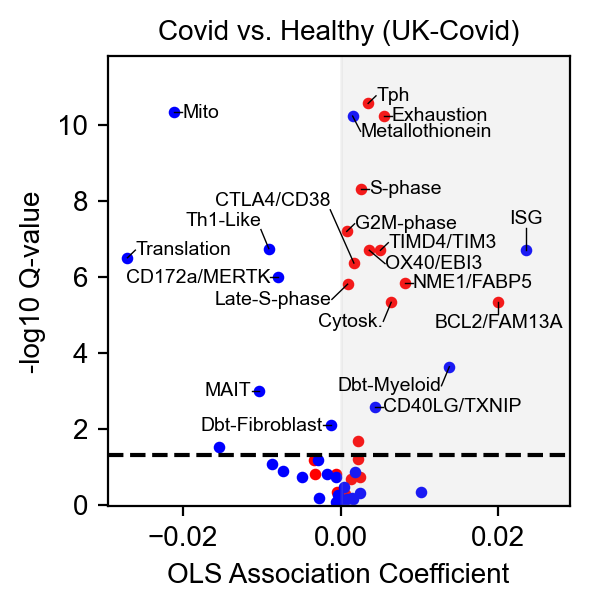

In [96]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200, gridspec_kw={'left':0.2, 'bottom':0.15, 'right':.97, 'top':.9})

dataset = 'UK-Covid'
p = 'COVID_vs_Healthy'
dat = all_results[dataset][p]
xval = 'Beta'
yval = 'logQ'
fs = 7

ind = dat.index.isin(aim)

ax.scatter(dat.loc[ind, xval], dat.loc[ind, yval],
           s=10, color='r', label='AIM-Assoc.')

ax.scatter(dat.loc[~ind, xval], dat.loc[~ind, yval],
           s=10, color='b', label='Other')

ax.set_xlabel('OLS Association Coefficient', fontsize=10)
ax.set_ylabel('-log10 Q-value', fontsize=10)
ax.set_title('Covid vs. Healthy (%s)' % dataset, fontsize=10)

labthresh=2

for g in dat.index:
    lab = shorten_map[g]

    if dat.at[g, yval]>labthresh:
        if g in ['MAIT', 'CD172a/MERTK', 'Doublet-Fibroblast']: deltax = -0.001; deltay =0; ha='right'; va='center' ## Left
        elif g in ['CellCycle-G2M',  'Tph', 'TIMD4/TIM3', 'Translation']: deltax = 0.001; deltay = .2; ha='left'; va='center' ## Upper-right
        elif g in ['Metallothionein']: deltax = 0.001; deltay = -.4; ha='left'; va='center' ## Lower-right
        elif g in ['OX40/EBI3']: deltax = 0.002; deltay = -.35; ha='left'; va='center' ## Lower-right

        elif g in []: deltax = 0.001; deltay = 0; ha='left'; va='top' ## Lower-right 2
        elif g in ['Doublet-Myeloid', 'Cytoskeleton']: deltax = -0.001; deltay =-0.5; ha='right'; va='center' ## Lower-Left
        elif g in [ 'CellCycle-Late-S',]: deltax = -0.002; deltay =-0.4; ha='right'; va='center' ## Lower-Left 2

        elif g in ['ISG', ]: deltax = 0; deltay =0.6; ha='center'; va='bottom' ## Above
        elif g in ['BCL2/FAM13A', ]: deltax = 0; deltay =-.3; ha='center'; va='top' ## Below
        
        
        
        
        elif g in ['Metallothionein', 'Th1-Like',]: deltax = -0.001; deltay =0.5; ha='right'; va='bottom' ## Upper-Left
        elif g in ['CTLA4/CD38']: deltax = -0.003; deltay =1.4; ha='right'; va='bottom' ## Upper-Left

        elif g in []: deltax = -0.001; deltay =0.2; ha='right'; va='bottom' ## Upper-Left 2
        else: deltax=.001; deltay=0; ha='left'; va='center' # Default to right

        ax.text(dat.at[g, xval]+deltax, dat.at[g, yval]+deltay, lab, ha=ha, va=va, fontsize=fs)
        ax.plot([dat.at[g, xval], dat.at[g, xval]+deltax], [dat.at[g, yval], dat.at[g, yval]+deltay], color='k', lw=.5)





xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.hlines(y=np.log10(0.05)*-1, xmin=xlim[0], xmax=xlim[1]+.005, linestyle='--', color='k')
ax.fill_between([0, xlim[1]+.5], [ylim[1]+1, ylim[1]+1], color='.7', alpha=.15)

ax.set_xlim(xlim[0], xlim[1]+.003)
ax.set_ylim(-0.05, ylim[1]+.5)

plt.savefig(os.path.join(figdir, 'CovidAssociation.%s.OLS.png' % dataset))
plt.savefig(os.path.join(figdir, 'CovidAssociation.%s.OLS.pdf' % dataset))


In [97]:
geps = ['Exhaustion', 'Metallothionein', 'TIMD4/TIM3', 'OX40/EBI3',
        'NME1/FABP5', 'BCL2/FAM13A', 'ICOS/CD38',
        'CTLA4/CD38', 'Cytoskeleton', 'CellCycle-G2M', 'CellCycle-S', 'CellCycle-Late-S',
       'HLA']
all_results[dataset][p].loc[geps, :]

,P,Beta,M0,M1,FC,log2_FC,Q,Pheno,logP,logQ
GEP,,,,,,,,,,
Exhaustion,4.600209e-12,0.005513,0.007005,0.014091,2.011637,1.008370,5.980271e-11,COVID_vs_Healthy,11.337222,10.223279
Metallothionein,3.734964e-12,0.001541,0.002887,0.004016,1.390931,0.476050,5.980271e-11,COVID_vs_Healthy,11.427714,10.223279
TIMD4/TIM3,3.750992e-08,0.005074,0.007472,0.013302,1.780149,0.831998,2.037103e-07,COVID_vs_Healthy,7.425854,6.690987
OX40/EBI3,3.305547e-08,0.003659,0.010521,0.014866,1.412976,0.498737,2.037103e-07,COVID_vs_Healthy,7.480757,6.690987
NME1/FABP5,3.896960e-07,0.008153,0.019850,0.030162,1.519465,0.603563,1.447442e-06,COVID_vs_Healthy,6.409274,5.839399
BCL2/FAM13A,1.556343e-06,0.020077,0.027281,0.045632,1.672702,0.742181,4.760578e-06,COVID_vs_Healthy,5.807895,5.322340
ICOS/CD38,4.249073e-01,0.000532,0.009940,0.010596,1.066020,0.092235,5.389069e-01,COVID_vs_Healthy,0.371706,0.268486
CTLA4/CD38,1.016579e-07,0.001698,0.007057,0.009200,1.303691,0.382602,4.405174e-07,COVID_vs_Healthy,6.992859,6.356037
Cytoskeleton,1.488299e-06,0.006440,0.018868,0.027057,1.434010,0.520055,4.760578e-06,COVID_vs_Healthy,5.827310,5.322340


In [98]:
geps = ['IEG', 'IEG2', 'IEG3']
all_results[dataset][p].loc[geps, :]

,P,Beta,M0,M1,FC,log2_FC,Q,Pheno,logP,logQ
GEP,,,,,,,,,,
IEG,0.958919,0.000194,0.037072,0.030015,0.809659,-0.304614,0.958919,COVID_vs_Healthy,0.018218,0.018218
IEG2,0.567588,0.001475,0.020320,0.020296,0.998790,-0.001747,0.672558,COVID_vs_Healthy,0.245967,0.172270
IEG3,0.632028,0.001633,0.028609,0.026240,0.917212,-0.124672,0.714467,COVID_vs_Healthy,0.199264,0.146018


In [99]:
geps = ['Tph', 'Treg']
all_results[dataset][p].loc[geps, :]

,P,Beta,M0,M1,FC,log2_FC,Q,Pheno,logP,logQ
GEP,,,,,,,,,,
Tph,5.344156e-13,0.003512,0.004401,0.008514,1.934861,0.952230,2.778961e-11,COVID_vs_Healthy,12.272121,10.556118
Treg,1.436012e-01,0.001350,0.017470,0.019086,1.092507,0.127642,2.074240e-01,COVID_vs_Healthy,0.842842,0.683141


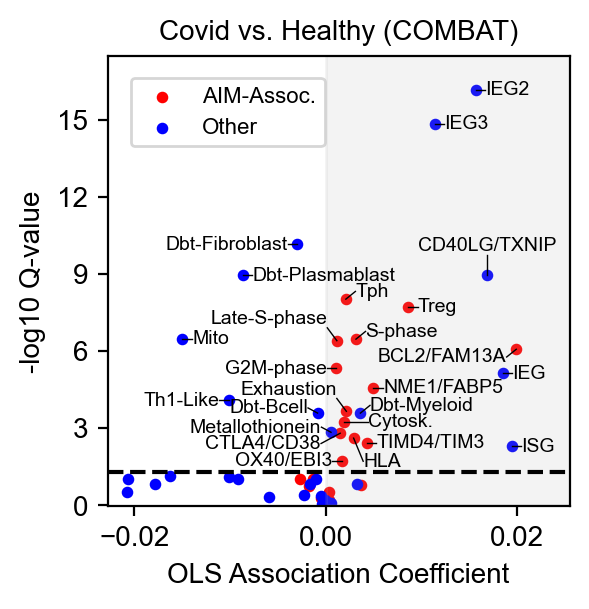

In [100]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200, gridspec_kw={'left':0.2, 'bottom':0.15, 'right':.97, 'top':.9})

dataset = 'COMBAT'
p = 'COVID_vs_Healthy'
dat = all_results[dataset][p]
xval = 'Beta'
yval = 'logQ'
fs = 7

ind = dat.index.isin(aim)

ax.scatter(dat.loc[ind, xval], dat.loc[ind, yval],
           s=10, color='r', label='AIM-Assoc.')

ax.scatter(dat.loc[~ind, xval], dat.loc[~ind, yval],
           s=10,  color='b', label='Other')

ax.set_xlabel('OLS Association Coefficient', fontsize=10)
ax.set_ylabel('-log10 Q-value', fontsize=10)
ax.set_title('Covid vs. Healthy (%s)' % dataset, fontsize=10)

labthresh=-1*np.log10(.05)

for g in dat.index:
    lab = shorten_map[g]

    if dat.at[g, yval]>labthresh:
        
        #if g == 'Doublet-Bcell':
        #    continue
        
        if g in ['Th1-Like', 'MAIT', 'Doublet-Fibroblast','CellCycle-G2M', 'OX40/EBI3']: deltax = -0.001; deltay =0; ha='right'; va='center' ## Left
        elif g in ['Tph',  'CellCycle-S', 'Doublet-Myeloid',]: deltax = 0.001; deltay = .3; ha='left'; va='center' ## Upper-right
        elif g in [  'HLA']: deltax = 0.001; deltay = -.9; ha='left'; va='center' ## Lower-right

        elif g in []: deltax = 0.001; deltay = 0; ha='left'; va='top' ## Lower-right 2
        elif g in ['BCL2/FAM13A']: deltax = -0.001; deltay =-0.3; ha='right'; va='center' ## Lower-Left
        elif g in ['CTLA4/CD38']: deltax = -0.002; deltay =-0.4; ha='right'; va='center' ## Lower-Left 2

        elif g in ['CD40LG/TXNIP']: deltax = 0; deltay =0.8; ha='center'; va='bottom' ## Above
        elif g in [ 'Exhaustion',   'CellCycle-Late-S', ]: deltax = -0.001; deltay =0.5; ha='right'; va='bottom' ## Upper-Left
        elif g in ['Metallothionein',  'Doublet-Bcell', ]: deltax = -0.001; deltay =0.2; ha='right'; va='center' ## Upper-Left 2
        elif g in ['Cytoskeleton',]: deltax = 0.0025; deltay =0; ha='left'; va='center' ## Right

        else: deltax=.001; deltay=0; ha='left'; va='center' # Default to right

        ax.text(dat.at[g, xval]+deltax, dat.at[g, yval]+deltay, lab, ha=ha, va=va, fontsize=fs)
        ax.plot([dat.at[g, xval], dat.at[g, xval]+deltax], [dat.at[g, yval], dat.at[g, yval]+deltay], color='k', lw=.5)


xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.hlines(y=np.log10(0.05)*-1, xmin=xlim[0], xmax=xlim[1]+.005, linestyle='--', color='k')
ax.fill_between([0, xlim[1]+.5], [ylim[1]+1, ylim[1]+1], color='.7', alpha=.15)

ax.set_xlim(xlim[0], xlim[1]+.003)
ax.set_ylim(-0.05, ylim[1]+.5)
ax.set_yticks([0, 3, 6, 9, 12, 15])
ax.set_xticks([-0.02, 0, 0.02])
ax.legend(loc = (.05, .8), fontsize=8)


plt.savefig(os.path.join(figdir, 'CovidAssociation.%s.OLS.png' % dataset))
plt.savefig(os.path.join(figdir, 'CovidAssociation.%s.OLS.pdf' % dataset))

In [101]:
dat.sort_values(by='Q')

,P,Beta,M0,M1,FC,log2_FC,Q,Pheno,logP,logQ
GEP,,,,,,,,,,
IEG2,1.323329e-18,0.015742,0.003931,0.019408,4.937044,2.303648,6.881311e-17,COVID_vs_Healthy,17.878332,16.162329
IEG3,5.348052e-17,0.011451,0.007538,0.018817,2.496275,1.319777,1.390494e-15,COVID_vs_Healthy,16.271804,14.856831
Doublet-Fibroblast,3.977674e-12,-0.002958,0.010229,0.007191,0.703043,-0.508315,6.894635e-11,COVID_vs_Healthy,11.400371,10.161489
CD40LG/TXNIP,9.351375e-11,0.016908,0.026988,0.043563,1.614148,0.690773,1.125653e-09,COVID_vs_Healthy,10.029125,8.948595
Doublet-Plasmablast,1.082359e-10,-0.008657,0.039105,0.029981,0.766675,-0.383313,1.125653e-09,COVID_vs_Healthy,9.965629,8.948595
Tph,1.098670e-09,0.002125,0.003650,0.005755,1.576844,0.657040,9.521809e-09,COVID_vs_Healthy,8.959133,8.021281
Treg,2.490356e-09,0.008653,0.019087,0.027562,1.443973,0.530044,1.849979e-08,COVID_vs_Healthy,8.603739,7.732833
Mito,5.947480e-08,-0.014975,0.023952,0.008689,0.362785,-1.462812,3.436322e-07,COVID_vs_Healthy,7.225667,6.463906
CellCycle-S,5.287316e-08,0.003183,0.001520,0.004627,3.042861,1.605428,3.436322e-07,COVID_vs_Healthy,7.276765,6.463906


In [102]:
geps = ['Exhaustion', 'Metallothionein', 'TIMD4/TIM3', 'OX40/EBI3',
        'NME1/FABP5', 'BCL2/FAM13A', 'ICOS/CD38',
        'CTLA4/CD38', 'Cytoskeleton', 'CellCycle-G2M', 'CellCycle-S', 'CellCycle-Late-S',
       'HLA']
all_results[dataset][p].loc[geps, :]

,P,Beta,M0,M1,FC,log2_FC,Q,Pheno,logP,logQ
GEP,,,,,,,,,,
Exhaustion,6.809109e-05,0.002178,0.005087,0.007273,1.429686,0.515698,2.212960e-04,COVID_vs_Healthy,4.166910,3.655026
Metallothionein,5.599468e-04,0.000570,0.002531,0.003121,1.233041,0.302221,1.455862e-03,COVID_vs_Healthy,3.251853,2.836880
TIMD4/TIM3,1.689709e-03,0.004325,0.004002,0.008157,2.038131,1.027247,3.820211e-03,COVID_vs_Healthy,2.772188,2.417913
OX40/EBI3,9.243369e-03,0.001691,0.006800,0.008667,1.274524,0.349959,1.922621e-02,COVID_vs_Healthy,2.034170,1.716106
NME1/FABP5,7.451905e-06,0.005019,0.005481,0.010559,1.926556,0.946024,2.767850e-05,COVID_vs_Healthy,5.127733,4.557857
BCL2/FAM13A,1.804072e-07,0.019962,0.021140,0.041873,1.980695,0.986007,8.528338e-07,COVID_vs_Healthy,6.743746,6.069136
ICOS/CD38,5.139466e-01,0.000396,0.006106,0.006533,1.069800,0.097342,6.073914e-01,COVID_vs_Healthy,0.289082,0.216531
CTLA4/CD38,6.390683e-04,0.001531,0.005294,0.006801,1.284669,0.361397,1.582455e-03,COVID_vs_Healthy,3.194453,2.800669
Cytoskeleton,2.088199e-04,0.001969,0.006532,0.008673,1.327908,0.409155,5.715070e-04,COVID_vs_Healthy,3.680228,3.242978


In [103]:
geps = ['IEG', 'IEG2', 'IEG3']
all_results[dataset][p].loc[geps, :]

,P,Beta,M0,M1,FC,log2_FC,Q,Pheno,logP,logQ
GEP,,,,,,,,,,
IEG,1.851789e-06,0.018527,0.013048,0.031990,2.451826,1.293857,7.407157e-06,COVID_vs_Healthy,5.732408,5.130348
IEG2,1.323329e-18,0.015742,0.003931,0.019408,4.937044,2.303648,6.881311e-17,COVID_vs_Healthy,17.878332,16.162329
IEG3,5.348052e-17,0.011451,0.007538,0.018817,2.496275,1.319777,1.390494e-15,COVID_vs_Healthy,16.271804,14.856831


In [104]:
geps = ['Tph', 'Treg']
all_results[dataset][p].loc[geps, :]

,P,Beta,M0,M1,FC,log2_FC,Q,Pheno,logP,logQ
GEP,,,,,,,,,,
Tph,1.098670e-09,0.002125,0.003650,0.005755,1.576844,0.657040,9.521809e-09,COVID_vs_Healthy,8.959133,8.021281
Treg,2.490356e-09,0.008653,0.019087,0.027562,1.443973,0.530044,1.849979e-08,COVID_vs_Healthy,8.603739,7.732833


In [105]:
aim

['Th17-Resting',
 'Treg',
 'Tph',
 'Tfh-2',
 'Th22',
 'CellCycle-G2M',
 'CTLA4/CD38',
 'Cytoskeleton',
 'Heatshock',
 'CellCycle-S',
 'ICOS/CD38',
 'NME1/FABP5',
 'OX40/EBI3',
 'Multi-Cytokine',
 'RGCC/MYADM',
 'Exhaustion',
 'CellCycle-Late-S',
 'TIMD4/TIM3',
 'BCL2/FAM13A',
 'HLA',
 'Th2-Activated',
 'Th17-Activated']

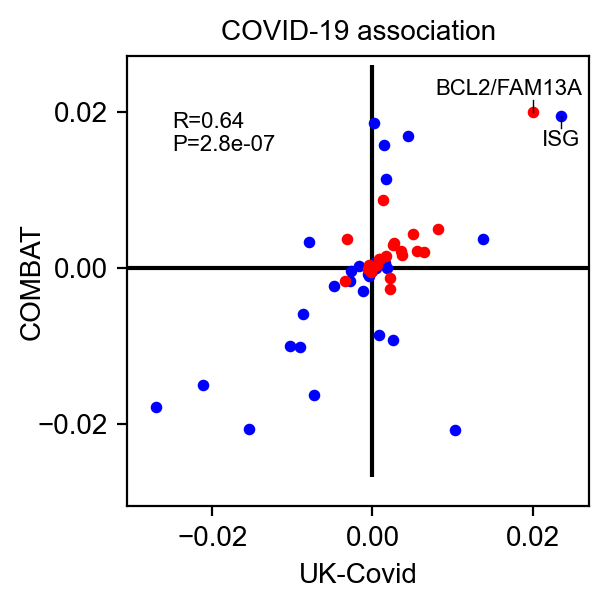

In [106]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200, gridspec_kw={'left':0.2, 'bottom':0.15, 'right':.97, 'top':.9})

p = 'COVID_vs_Healthy'
xval = 'Beta'
d1 = 'UK-Covid'
d2 = 'COMBAT'

dat1 = all_results[d1][p]
dat2 = all_results[d2][p]

ind = dat1.index.isin(aim)



ax.scatter(dat1.loc[~ind, xval],
         dat2.loc[~ind, xval], s=10, color='b', label='Other')

ax.scatter(dat1.loc[ind, xval],
         dat2.loc[ind, xval], s=10, color='r', label='AIM')

#ax.scatter(all_results[d1][p].loc[~ind, xval],
#         all_results[d2][p].loc[~ind, xval], s=10, edgecolor='None',
#        color='b', label='Other')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.hlines(y=0, xmin=xlim[0]-.004, xmax=xlim[1]+.004, color='k', zorder=-1)
ax.vlines(x=0, ymin=ylim[0]-.004, ymax=ylim[1]+.004, color='k', zorder=-1)

ax.set_xlim(xlim[0]-.001, xlim[1]+.001)
ax.set_ylim(xlim[0]-.001, xlim[1]+.001)

ax.set_xlabel('UK-Covid', fontsize=10)
ax.set_ylabel('COMBAT', fontsize=10, labelpad=-3)
ax.set_title('COVID-19 association', fontsize=10)

R,P = pearsonr(dat1[xval], dat2[xval])

ax.text(-.025, .018, 'R=%.2f' % R, fontsize=8)
ax.text(-.025, .015, 'P=%.1e' % P, fontsize=8)
ax.set_yticks([-0.02, 0.0, 0.02])

g = 'ISG'
ax.text(dat1.loc[g, 'Beta'], dat2.loc[g, 'Beta']-.003, g, fontsize=8, ha='center', va='center')
ax.plot([dat1.loc[g, 'Beta'], dat1.loc[g, 'Beta']], [ dat2.loc[g, 'Beta'], dat2.loc[g, 'Beta']-.0015], color='k', lw=.5)


g = 'BCL2/FAM13A'
ax.text(dat1.loc[g, 'Beta']-.003, dat2.loc[g, 'Beta']+.003, g, fontsize=8, ha='center', va='center')
ax.plot([dat1.loc[g, 'Beta'], dat1.loc[g, 'Beta']], [ dat2.loc[g, 'Beta'], dat2.loc[g, 'Beta']+.0015], color='k', lw=.5)

plt.savefig(os.path.join(figdir, 'CovidAssociation.DatasetCorrelation.png'))
plt.savefig(os.path.join(figdir, 'CovidAssociation.DatasetCorrelation.pdf'))

1.2747169271355857e-05


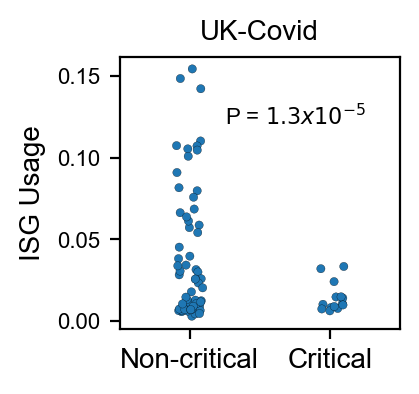

In [107]:
(fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=200,
                        gridspec_kw={'left':.28, 'bottom':.2, 'right':0.98})

X = sample_data['UK-Covid']['COVID_Severe_vs_Mild']
X['Status'] = X['COVID_Severe_vs_Mild'].replace({1:'Critical', 0:'Non-critical'})

sns.stripplot(x='Status', y='ISG',
            data=X, ax=ax,
            size=3, edgecolor='k', linewidth=.1, color=sns.color_palette("tab10")[0])

ax.set_xlabel('')
ax.set_ylabel('ISG Usage', fontsize=10)
ax.set_xticklabels(['Non-critical', 'Critical'], fontsize=10)
ax.tick_params(axis='y', labelsize=8)
ax.set_title('UK-Covid', fontsize=10)
#ax.text(0.4, .12, s='P=%.6f' % all_results['UK-Covid']['COVID_Severe_vs_Mild'].loc['ISG', 'P'], fontsize=10)
print(all_results['UK-Covid']['COVID_Severe_vs_Mild'].loc['ISG', 'P'])
ax.text(0.25, .12, s='P = $1.3x10^{-5}$' % all_results['UK-Covid']['COVID_Severe_vs_Mild'].loc['ISG', 'P'], fontsize=8)

plt.savefig(os.path.join(figdir, 'CovidCriticalVsNon.UKCovid.png'))
plt.savefig(os.path.join(figdir, 'CovidCriticalVsNon.UKCovid.pdf'))

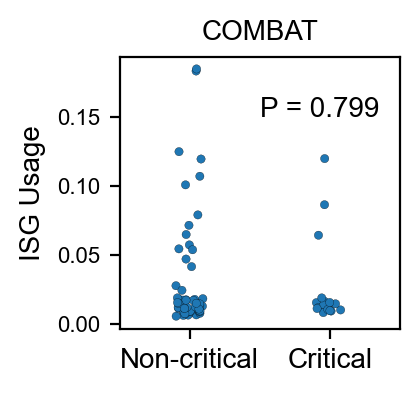

In [108]:
(fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=200,
                        gridspec_kw={'left':.28, 'bottom':.2, 'right':0.98})

X = sample_data['COMBAT']['COVID_Severe_vs_Mild']
X['Status'] = X['COVID_Severe_vs_Mild'].replace({1:'Critical', 0:'Non-critical'})
X = pd.merge(left=X, right=allmeta['COMBAT'][['COMBAT_ID', 'Outcome']].drop_duplicates(), how='left', left_index=True, right_on='COMBAT_ID')
X['Status2'] = X['Outcome'].replace({1:'Death', 2:'Intubated', 3:'NiV', 4:'O2', 5:'No O2', 6:'Not hospitalized'})


sns.stripplot(x='Status', y='ISG',
            data=X, ax=ax,
            size=3, edgecolor='k', linewidth=.1, color=sns.color_palette("tab10")[0])

ax.set_xlabel('')
ax.set_ylabel('ISG Usage', fontsize=10)
ax.set_xticklabels(['Non-critical', 'Critical'], fontsize=10)
ax.tick_params(axis='y', labelsize=8)
ax.set_title('COMBAT', fontsize=10)
ax.text(0.5, .15, s='P = %.3f' % all_results['COMBAT']['COVID_Severe_vs_Mild'].loc['ISG', 'P'], fontsize=10)
#ax.legend(bbox_to_anchor=(1,1), fontsize=5)

plt.savefig(os.path.join(figdir, 'CovidCriticalVsNon.COMBAT.png'))
plt.savefig(os.path.join(figdir, 'CovidCriticalVsNon.COMBAT.pdf'))

# RA

In [109]:
dataset = 'AMP-RA'
sample_col = params.loc[dataset, 'sample_col']
individual_col = params.loc[dataset, 'individual_col']
usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t').rename(columns=rename_map)
usage = usage.div(usage.sum(axis=1), axis=0)
meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], sep = '\t', index_col = 0)
sample_metafn = '/data/srlab1/mcurtis/GSK/tcell_proliferation/AMP_ADT/data/AMP_sample_metadata.txt'
sample_meta = pd.read_csv(sample_metafn, index_col = 0, sep = '\t')
meta = pd.merge(meta, sample_meta, left_on = 'sample', right_index = True, 
                how = 'left')
meta = meta.loc[usage.index, :]

### Add a CTAP col with OA
meta['CTAP'] = meta['new_class']
meta.loc[meta['CTAP'].isna() & (meta['treatment']=='OA'), 'CTAP'] = 'OA'

### Add a OA/RA col
meta['disease_status'] = meta['CTAP']
meta.loc[(meta['disease_status']!='OA') & (-meta['disease_status'].isna()), 'disease_status'] = 'RA'
meta['cell'] = meta.index

all_results[dataset] = {}
sample_data[dataset] = {}

In [110]:
meta['RA_vs_OA'] = meta['disease_status'].replace({'RA':1, 'OA':0})

In [111]:
meta[['RA_vs_OA', individual_col]].dropna().drop_duplicates()['RA_vs_OA'].value_counts()

1.0    70
0.0     8
Name: RA_vs_OA, dtype: int64

In [112]:
cat_covars = []
#q_covars = ['nCount_RNA']
q_covars = []

In [113]:
for p in ['RA_vs_OA']:
    pc, cc, sample_level = test_association_unpaired(meta, usage, p,
                                            individual_col, cat_covar_cols=cat_covars, quant_covar_cols=q_covars,
                                            _min_cell_thresh=min_cells, method='OLS')

    all_results[dataset][p] = pc
    sample_data[dataset][p] = sample_level

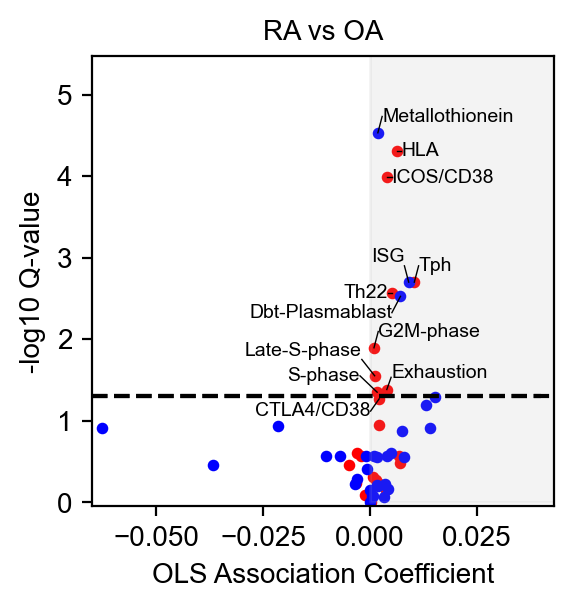

In [116]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200, gridspec_kw={'left':0.2, 'bottom':0.15, 'right':.97, 'top':.9})

dataset = 'AMP-RA'
p = 'RA_vs_OA'
dat = all_results[dataset][p]
xval = 'Beta'
yval = 'logQ'
fs = 7

ind = dat.index.isin(aim)

ax.scatter(dat.loc[ind, xval], dat.loc[ind, yval],
           s=10, color='r', label='AIM')

ax.scatter(dat.loc[~ind, xval], dat.loc[~ind, yval],
           s=10, color='b', label='Other')

ax.set_xlabel('OLS Association Coefficient', fontsize=10)
ax.set_ylabel('-log10 Q-value', fontsize=10)
ax.set_title('RA vs OA', fontsize=10)

labthresh=-1*np.log10(.05)

for g in dat.index:
    lab = shorten_map[g]

    if (dat.at[g, yval]>labthresh) or (g == 'CTLA4/CD38'):
        
        if g == 'Doublet-Bcell':
            continue
        
        if g in [   'Th22']: deltax = -0.001; deltay =0; ha='right'; va='center' ## Left
        elif g in ['Tph',  'TIMD4/TIM3', 'Metallothionein', 'CellCycle-G2M',  'Exhaustion',]: deltax = 0.001; deltay = .2; ha='left'; va='center' ## Upper-right
        elif g in [ ]: deltax = 0.005; deltay = .35; ha='center'; va='center' ## Upper-right

        elif g in []: deltax = 0.001; deltay = -.3; ha='left'; va='center' ## Lower-right
        elif g in ['Cytoskeleton', 'OX40/EBI3']: deltax = 0.001; deltay = -.5; ha='left'; va='center' ## Lower-right

        elif g in []: deltax = 0.001; deltay = 0; ha='left'; va='top' ## Lower-right 2
        elif g in ['Doublet-Plasmablast']: deltax = -0.002; deltay =-0.2; ha='right'; va='center' ## Lower-Left
        elif g in ['CTLA4/CD38', ]: deltax = -0.002; deltay =-0.15; ha='right'; va='center' ## Lower-Left 2

        elif g in [ ]: deltax = 0; deltay =0.1; ha='center'; va='bottom' ## Above
        elif g in [ 'CellCycle-S', ]: deltax = -0.004; deltay =0.2; ha='right'; va='center' ## Upper-Left
        elif g in ['ISG', ]: deltax = -0.001; deltay =0.2; ha='right'; va='bottom' ## Upper-Left 2
        elif g in ['CellCycle-Late-S']: deltax = -0.003; deltay =0.2; ha='right'; va='bottom' ## Upper-Left 2

        else: deltax=.001; deltay=0; ha='left'; va='center' # Default to right

        if g not in ['Exhaustion']:
            ax.text(dat.at[g, xval]+deltax, dat.at[g, yval]+deltay, lab, ha=ha, va=va, fontsize=fs)
            ax.plot([dat.at[g, xval], dat.at[g, xval]+deltax], [dat.at[g, yval], dat.at[g, yval]+deltay], color='k', lw=.5)
        else:
            ax.text(dat.at[g, xval]+deltax, dat.at[g, yval]+deltay, lab, ha=ha, va=va, fontsize=fs)
            ax.plot([dat.at[g, xval], dat.at[g, xval]+deltax], [dat.at[g, yval], dat.at[g, yval]+deltay-.05], color='k', lw=.5)



ax.set_xlim([-0.065, 0.04])
xlim = ax.get_xlim()

ax.hlines(y=np.log10(0.05)*-1, xmin=xlim[0], xmax=xlim[1], linestyle='--', color='k')
ax.set_xlim(xlim)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.hlines(y=np.log10(0.05)*-1, xmin=xlim[0], xmax=xlim[1]+.005, linestyle='--', color='k')
ax.fill_between([0, xlim[1]+.5], [ylim[1]+1, ylim[1]+1], color='.7', alpha=.15)

ax.set_xlim(xlim[0], xlim[1]+.003)
ax.set_ylim(-0.05, ylim[1]+.5)

plt.savefig(os.path.join(figdir, 'RAAssociation.%s.OLS.png' % dataset))
plt.savefig(os.path.join(figdir, 'RAAssociation.%s.OLS.pdf' % dataset))

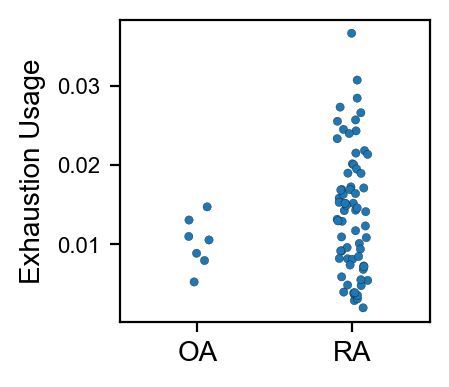

In [117]:
(fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=200)
gep = 'Exhaustion'
X = sample_data[dataset][p]
sns.stripplot(x=p, y=gep,
            data=X, ax=ax,
            size=3, edgecolor='k', linewidth=.1, color=sns.color_palette("tab10")[0])

ax.set_xlabel('')
ax.set_ylabel('%s Usage' % gep, fontsize=10)
ax.set_xticklabels(['OA', 'RA'], fontsize=10)
ax.tick_params(axis='y', labelsize=8)
#ax.set_title('COMBAT', fontsize=10)
#ax.text(0.5, .15, s='P=%.3f' % all_results['COMBAT']['COVID_Severe_vs_Mild'].loc['ISG', 'P'], fontsize=10)
#ax.legend(bbox_to_anchor=(1,1), fontsize=5)

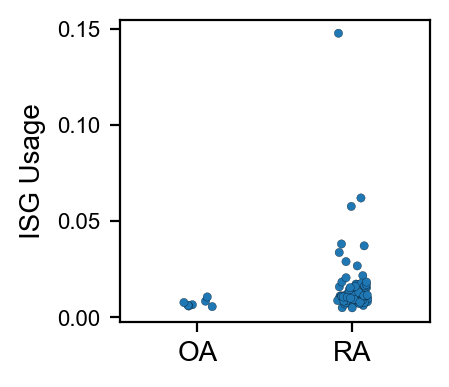

In [118]:
(fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=200)
gep = 'ISG'
X = sample_data[dataset][p]
sns.stripplot(x=p, y=gep,
            data=X, ax=ax,
            size=3, edgecolor='k', linewidth=.1, color=sns.color_palette("tab10")[0])

ax.set_xlabel('')
ax.set_ylabel('%s Usage' % gep, fontsize=10)
ax.set_xticklabels(['OA', 'RA'], fontsize=10)
ax.tick_params(axis='y', labelsize=8)
#ax.set_title('COMBAT', fontsize=10)
#ax.text(0.5, .15, s='P=%.3f' % all_results['COMBAT']['COVID_Severe_vs_Mild'].loc['ISG', 'P'], fontsize=10)
#ax.legend(bbox_to_anchor=(1,1), fontsize=5)

# Cancer - duplicates filtered

In [220]:
dataset = 'Pan-Cancer'
sample_col = params.loc[dataset, 'sample_col']
individual_col = params.loc[dataset, 'individual_col']
usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t').rename(columns=rename_map)
usage = usage.div(usage.sum(axis=1), axis=0)

meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], sep = '\t', index_col = 0)
meta = meta.loc[usage.index, :]

all_results[dataset] = {}
sample_data[dataset] = {}

In [221]:
fixed_idv_col = 'patient.uid.sampletype'

In [222]:
meta['Cancer_Or_Not'] = meta['loc'].replace({'T':1.0, 'N':0.0})

In [223]:
meta[fixed_idv_col]= meta[individual_col] + ' - ' + meta['loc']

In [224]:
cell_counts = meta[sample_col].value_counts()
dd = meta[[fixed_idv_col, sample_col]].drop_duplicates()
dd.index = dd['sampleID']
dd['cell_counts'] = cell_counts.loc[dd.index]
ddfilt = dd.sort_values(by='cell_counts', ascending=False).drop_duplicates(subset='patient.uid.sampletype')
#ddfilt = ddfilt.loc[ddfilt['cell_counts']>19, :]

tokeep = meta['patient.uid.sampletype'].isin(ddfilt['patient.uid.sampletype']) & meta['sampleID'].isin(ddfilt['sampleID'])
meta =meta.loc[tokeep, :]
usage = usage.loc[tokeep, :]

In [225]:
dd = meta[[fixed_idv_col, sample_col]].drop_duplicates()
dd['patient.uid.sampletype'].value_counts().head()

BCC.KathrynEYost2019.su001 - T    1
RC.thisStudy.RC.P20190918 - N     1
RC.MatthewDYoung2018.RCC2 - N     1
RC.MatthewDYoung2018.RCC3 - N     1
RC.thisStudy.RC.P20181217 - N     1
Name: patient.uid.sampletype, dtype: int64

In [226]:
dd = meta[['patient.uid.sampletype', 'loc', 'cancerType']].drop_duplicates()
ct = pd.crosstab(dd['loc'], dd['cancerType'])

In [227]:
ct.sum(axis=1)

loc
N    47
T    89
dtype: int64

In [228]:
ct

cancerType,BC,BCC,BCL,ESCA,FTC,HCC,LUNG,MM,OV,PACA,RC,THCA,UCEC
loc,,,,,,,,,,,,,
N,2,0,0,7,0,5,4,0,1,1,11,8,8
T,2,11,2,7,1,5,2,3,1,26,10,10,9


In [229]:
pd.crosstab(meta['loc'], meta['cancerType'])

cancerType,BC,BCC,BCL,ESCA,FTC,HCC,LUNG,MM,OV,PACA,RC,THCA,UCEC
loc,,,,,,,,,,,,,
N,3206,0,0,9768,0,5067,1018,0,909,505,11432,28669,14752
T,4148,14346,3493,15114,1037,3897,187,8279,3613,10999,17189,28287,17900


In [230]:
cat_covars = ['cancerType', 'dataset.tech']
#q_covars = ['n_counts']
q_covars = []

In [231]:
for p in ['Cancer_Or_Not']:
    pc, cc, sample_level = test_association_unpaired(meta, usage, p,
                                            fixed_idv_col, cat_covar_cols=cat_covars, quant_covar_cols=q_covars,
                                            _min_cell_thresh=min_cells, method='OLS')

    all_results[dataset][p] = pc
    sample_data[dataset][p] = sample_level

In [232]:
all_results[dataset][p].index

Index(['CellCycle-G2M', 'Translation', 'HLA', 'ISG', 'Mito', 'Doublet-RBC',
       'gdT', 'CellCycle-S', 'Cytotoxic', 'Doublet-Platelet', 'NME1/FABP5',
       'Th22', 'MAIT', 'CellCycle-Late-S', 'Cytoskeleton', 'Heatshock',
       'Multi-Cytokine', 'TEMRA', 'Doublet-Myeloid', 'Metallothionein',
       'CD4-CM', 'IEG', 'CD8-EM', 'IEG2', 'CD4-Naive', 'Treg', 'Th17-Resting',
       'Poor-Quality', 'CD8-Naive', 'RGCC/MYADM', 'TIMD4/TIM3',
       'Doublet-Plasmablast', 'BCL2/FAM13A', 'IL10/IL19', 'Th2-Activated',
       'Th2-Resting', 'ICOS/CD38', 'Doublet-Bcell', 'Th1-Like', 'CTLA4/CD38',
       'CD8-Trm', 'Th17-Activated', 'Tfh-2', 'OX40/EBI3', 'CD172a/MERTK',
       'IEG3', 'Doublet-Fibroblast', 'SOX4/TOX2', 'CD40LG/TXNIP', 'Tph',
       'Exhaustion', 'Tfh-1'],
      dtype='object', name='GEP')

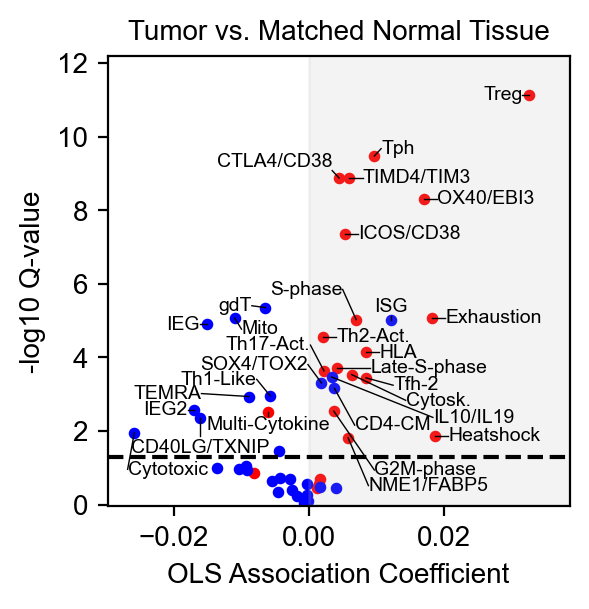

In [233]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200, gridspec_kw={'left':0.2, 'bottom':0.15, 'right':.97, 'top':.9})

dataset = 'Pan-Cancer'
p = 'Cancer_Or_Not'
dat = all_results[dataset][p]
xval = 'Beta'
yval = 'logQ'
fs = 7

ind = dat.index.isin(aim)

ax.scatter(dat.loc[ind, xval], dat.loc[ind, yval],
           s=10,  color='r', label='AIM')

ax.scatter(dat.loc[~ind, xval], dat.loc[~ind, yval],
           s=10, color='b', label='Other')

ax.set_xlabel('OLS Association Coefficient', fontsize=10)
ax.set_ylabel('-log10 Q-value', fontsize=10)
ax.set_title('Tumor vs. Matched Normal Tissue', fontsize=10)

labthresh=-1*np.log10(.05)

for g in dat.index:
    lab = shorten_map[g]

    if (dat.at[g, yval]>labthresh) or (g == 'CTLA4+/CD38+-Activation'):
        
        if g in [  'CD8-Naive']:
            continue
        
        if g in [ 'Treg', 'Metallothionein','Th22', 'IEG', 'IEG2',]: deltax = -0.001; deltay =0; ha='right'; va='center' ## Left
        elif g in [ 'CellCycle-Late-S', ]: deltax = 0.005; deltay = 0; ha='left'; va='center' ## Right
        
        
       
        elif g in ['Tph', ]: deltax = 0.001; deltay = .2; ha='left'; va='center' ## Upper-right
        elif g in []: deltax = 0.004; deltay = .5; ha='center'; va='center' ## Upper-right

        elif g in ['Mito', ]: deltax = 0.001; deltay = -.3; ha='left'; va='center' ## Lower-right
        elif g in [ 'Tfh-2']: deltax = 0.004; deltay = -.2; ha='left'; va='center' ## Lower-right
        elif g in [ ]: deltax = 0.001; deltay = -.6; ha='left'; va='center' ## Lower-right
        elif g in [  'CellCycle-G2M',]: deltax = 0.006; deltay = -1.6; ha='left'; va='center' ## Lower-right
        elif g in [  'Cytotoxic',]: deltax = -0.001; deltay = -1; ha='left'; va='center' ## Lower-right        

        elif g in [ 'Cytoskeleton']: deltax = 0.008; deltay = -.7; ha='left'; va='center' ## Lower-right
        elif g in [ 'CD4-CM',]: deltax = 0.003; deltay = -1.; ha='left'; va='center' ## Lower-right
        elif g in [ 'NME1/FABP5']: deltax = 0.003; deltay = -1.3; ha='left'; va='center' ## Lower-right
        elif g in [ 'IL10/IL19',]: deltax = 0.015; deltay = -1.1; ha='left'; va='center' ## Lower-right

        
            
        elif g in ['Doublet-Plasmablast',]: deltax = -0.001; deltay =-0.2; ha='right'; va='center' ## Lower-Left
        elif g in ['CD172a/MERTK' ]: deltax = -0.002; deltay =-0.5; ha='right'; va='center' ## Lower-Left 2
        elif g in [ 'CD40LG/TXNIP',]: deltax = 0; deltay = -.8; ha='center'; va='center' ## Lower-right        

        
        elif g in ['ISG',  ]: deltax = 0; deltay =0.1; ha='center'; va='bottom' ## Above
        elif g in ['Multi-Cytokine']: deltax = 0; deltay =-0.1; ha='center'; va='top' ## Below
        
        
        
        
        elif g in [ 'gdT', ]: deltax = -0.002; deltay =0.05; ha='right'; va='center' ## Upper-Left
        elif g in [   'TEMRA', ]: deltax = -0.007; deltay =0.08; ha='right'; va='center' ## Upper-Left

        elif g in [ 'Th1-Like' ]: deltax = -0.002; deltay =0.45; ha='right'; va='center' ## Upper-Left        

        elif g in ['SOX4/TOX2' ]: deltax = -0.002; deltay =0.5; ha='right'; va='center' ## Upper-Left        
        elif g in ['Th17-Activated',]: deltax = -0.002; deltay =0.7; ha='right'; va='center' ## Upper-Left

        elif g in [  'CellCycle-S', ]: deltax = -0.002; deltay =0.82; ha='right'; va='center' ## Upper-Left

        elif g in ['CTLA4/CD38']: deltax = -0.001; deltay =0.2; ha='right'; va='bottom' ## Upper-Left 2
        else: deltax=.002; deltay=0; ha='left'; va='center' # Default to right

        if g not in ['CD40LG/TXNIP',]:
            ax.text(dat.at[g, xval]+deltax, dat.at[g, yval]+deltay, lab, ha=ha, va=va, fontsize=fs)
            ax.plot([dat.at[g, xval], dat.at[g, xval]+deltax], [dat.at[g, yval], dat.at[g, yval]+deltay], color='k', lw=.5)
        else:
            ax.text(dat.at[g, xval]+deltax, dat.at[g, yval]+deltay, lab, ha=ha, va=va, fontsize=fs)
            ax.plot([dat.at[g, xval], dat.at[g, xval]+deltax], [dat.at[g, yval], dat.at[g, yval]+deltay+.3], color='k', lw=.5)


xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.hlines(y=np.log10(0.05)*-1, xmin=xlim[0], xmax=xlim[1]+.005, linestyle='--', color='k')
ax.fill_between([0, xlim[1]+.5], [ylim[1]+1, ylim[1]+1], color='.7', alpha=.15)

ax.set_xlim(xlim[0], xlim[1]+.003)
ax.set_ylim(-0.05, ylim[1]+.5)

plt.savefig(os.path.join(figdir, 'CancerAssociation.%s.OLS.png' % dataset))
plt.savefig(os.path.join(figdir, 'CancerAssociation.%s.OLS.pdf' % dataset))

In [234]:
aim

['Th17-Resting',
 'Treg',
 'Tph',
 'Tfh-2',
 'Th22',
 'CellCycle-G2M',
 'CTLA4/CD38',
 'Cytoskeleton',
 'Heatshock',
 'CellCycle-S',
 'ICOS/CD38',
 'NME1/FABP5',
 'OX40/EBI3',
 'Multi-Cytokine',
 'RGCC/MYADM',
 'Exhaustion',
 'CellCycle-Late-S',
 'TIMD4/TIM3',
 'BCL2/FAM13A',
 'HLA',
 'Th2-Activated',
 'Th17-Activated']

In [235]:
set(aim) - set(dat.index)

set()

In [236]:
dat = all_results[dataset][p]



ct = pd.crosstab((dat['Q']<.05) & (dat['Beta']>0), dat.index.isin(aim))
ct

col_0,False,True
row_0,,
False,26,5
True,4,17


In [237]:
from scipy.stats import fisher_exact
fisher_exact(ct)

(22.1, 7.434465422006353e-06)

In [238]:
dat.sort_values(by='P')

,P,Beta,M0,M1,FC,log2_FC,Q,Pheno,logP,logQ
GEP,,,,,,,,,,
Treg,1.428021e-13,0.032582,0.016588,0.041458,2.499268,1.321506,7.425712e-12,Cancer_Or_Not,12.845265,11.129262
Tph,1.282957e-11,0.009659,0.010530,0.019901,1.889921,0.918326,3.335689e-10,Cancer_Or_Not,10.891788,9.476814
CTLA4/CD38,7.864279e-11,0.004429,0.005748,0.009964,1.733548,0.793728,1.315899e-09,Cancer_Or_Not,10.104341,8.880777
TIMD4/TIM3,1.012230e-10,0.005946,0.007560,0.013865,1.833961,0.874963,1.315899e-09,Cancer_Or_Not,9.994721,8.880777
OX40/EBI3,4.707780e-10,0.016987,0.006415,0.022478,3.503825,1.808931,4.896092e-09,Cancer_Or_Not,9.327184,8.310150
ICOS/CD38,5.024489e-09,0.005315,0.005958,0.010695,1.794949,0.843943,4.354557e-08,Cancer_Or_Not,8.298908,7.361056
gdT,5.924890e-07,-0.006466,0.019616,0.012606,0.642632,-0.637935,4.401347e-06,Cancer_Or_Not,6.227320,5.356414
Mito,1.380103e-06,-0.011001,0.024754,0.012985,0.524581,-0.930763,8.507092e-06,Cancer_Or_Not,5.860089,5.070219
Exhaustion,1.472381e-06,0.018140,0.011548,0.026602,2.303580,1.203878,8.507092e-06,Cancer_Or_Not,5.831980,5.070219


# Plot usage vs. CXCL13 expression

In [251]:
dataset

'Pan-Cancer'

In [252]:
adata = sc.read(params.loc[dataset, 'raw_counts_fn'])
adata = adata[meta.index, :].copy()

Only considering the two last: ['.NoPBMC', '.h5ad'].
Only considering the two last: ['.NoPBMC', '.h5ad'].


In [253]:
adata.X = adata.X.astype(float)

In [254]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [255]:
sc.pp.log1p(adata)

In [256]:
X = pd.DataFrame(adata[:,['CXCL13']].X.toarray(), index=adata.obs.index, columns=['CXCL13'])

In [257]:
'IL21' in adata.var.index

False

In [275]:
X = usage[['Tph', 'Tfh-1', 'Tfh-2']]
X['CXCL13'] = adata[X.index, :].obs_vector('CXCL13')
X['individual'] = meta.loc[X.index, fixed_idv_col]
X['loc'] = meta.loc[X.index, 'loc']
X['cancerType'] = meta.loc[X.index, 'cancerType']

sample_average = X.groupby(['individual', 'loc', 'cancerType']).mean().reset_index()
sample_average.head()

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be se

,individual,loc,cancerType,Tph,Tfh-1,Tfh-2,CXCL13
0,BCC.KathrynEYost2019.su001 - T,T,BCC,0.023381,0.007925,0.055868,0.691190
1,BCC.KathrynEYost2019.su002 - T,T,BCC,0.041355,0.005613,0.028515,0.486731
2,BCC.KathrynEYost2019.su003 - T,T,BCC,0.028590,0.005261,0.023681,0.319401
3,BCC.KathrynEYost2019.su004 - T,T,BCC,0.014007,0.005215,0.028131,0.144394
4,BCC.KathrynEYost2019.su005 - T,T,BCC,0.036980,0.010292,0.023712,0.562445


In [302]:
pearsonr(sample_average['Tph'], sample_average['CXCL13'])

(0.670791420055077, 4.1070086289407696e-19)

In [303]:
ind = sample_average['loc']=='T'
pearsonr(sample_average.loc[ind, 'Tph'], sample_average.loc[ind, 'CXCL13'])

(0.6857148828560027, 1.2250283806053094e-13)

In [304]:
ind = sample_average['loc']!='T'
pearsonr(sample_average.loc[ind, 'Tph'], sample_average.loc[ind, 'CXCL13'])

(0.33599756404395287, 0.020941636875084286)

In [305]:
pearsonr(sample_average['Tfh-2'], sample_average['CXCL13'])

(0.44687914662459033, 4.935264722289982e-08)

In [306]:
ind = sample_average['loc']=='T'
pearsonr(sample_average.loc[ind, 'Tfh-2'], sample_average.loc[ind, 'CXCL13'])

(0.3106247390082475, 0.003049941756560671)

In [307]:
ind = sample_average['loc']!='T'
pearsonr(sample_average.loc[ind, 'Tfh-2'], sample_average.loc[ind, 'CXCL13'])

(0.7701277213659773, 2.476155273910789e-10)

In [308]:
import statsmodels.api as sm

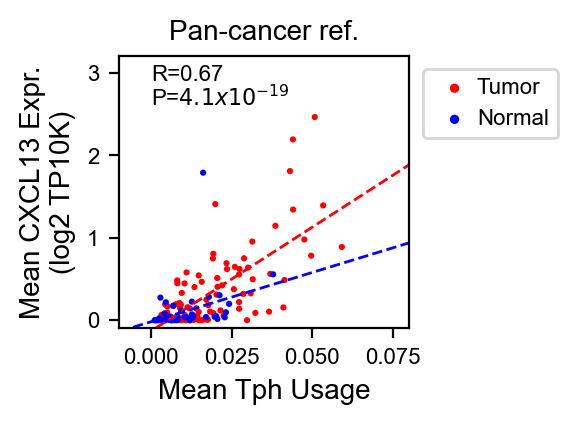

In [312]:
mean_tph_usage = usage.groupby(meta[fixed_idv_col]).mean()['Tph']
mean_cxcl3 = X.groupby(meta[fixed_idv_col]).mean()['CXCL13']

sampinfo = meta[[fixed_idv_col, 'cancerType', 'loc']].drop_duplicates()
sampinfo.index = sampinfo[fixed_idv_col]
sampinfo = sampinfo.loc[mean_cxcl3.index, :]

tumor_ind = sampinfo['loc'] == 'T'

R,P = pearsonr(mean_tph_usage, mean_cxcl3)

(fig,ax) = plt.subplots(1, 1, figsize=(2.9,2), dpi=200, gridspec_kw={'left':.2, 'bottom':.2, 'right':.7})

ax.scatter(mean_tph_usage.loc[tumor_ind], mean_cxcl3.loc[tumor_ind], label='Tumor', color='r', s=5, edgecolor='None')
ax.scatter(mean_tph_usage.loc[~tumor_ind], mean_cxcl3.loc[~tumor_ind], label='Normal', color='b', s=5, edgecolor='None')

ax.set_xlabel('Mean Tph Usage', fontsize=10)
ax.set_ylabel('Mean CXCL13 Expr.\n(log2 TP10K)', fontsize=10)
ax.set_title('Pan-cancer ref.', fontsize=10)
ax.tick_params(labelsize=8)
ax.set_ylim([-.1, 3.2])
ax.set_xlim([-.01, .08])

ax.legend(bbox_to_anchor=(1.05,.7), fontsize=8, markerscale=1.5, handletextpad=0, loc=(.02, .74))
ax.text(0.0, 2.9, 'R=%.2f' % R, fontsize=8)
ax.text(0.0, 2.6, 'P=$4.1x10^{-19}$' % R, fontsize=8)

xlim = ax.get_xlim()
ylim = ax.get_ylim()


predictor = sm.add_constant(mean_tph_usage.loc[tumor_ind])
res = sm.OLS(endog=mean_cxcl3.loc[tumor_ind], exog=predictor).fit()
ypred = res.params.loc['const'] + (res.params.loc['Tph']*np.array(xlim))
ax.plot(xlim, ypred, linestyle='--', color='r', lw=1)

predictor = sm.add_constant(mean_tph_usage.loc[~tumor_ind])
res = sm.OLS(endog=mean_cxcl3.loc[~tumor_ind], exog=predictor).fit()
ypred = res.params.loc['const'] + (res.params.loc['Tph']*np.array(xlim))
ax.plot(xlim, ypred, linestyle='--', color='b', lw=1)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.savefig(os.path.join(figdir, 'CancerAssociation.CXCL13.Corr.png'))
plt.savefig(os.path.join(figdir, 'CancerAssociation.CXCL13.Corr.pdf'))

array([-0.38211829,  1.8841405 ])

Text(0.035, 3.0, 'R=0.45')

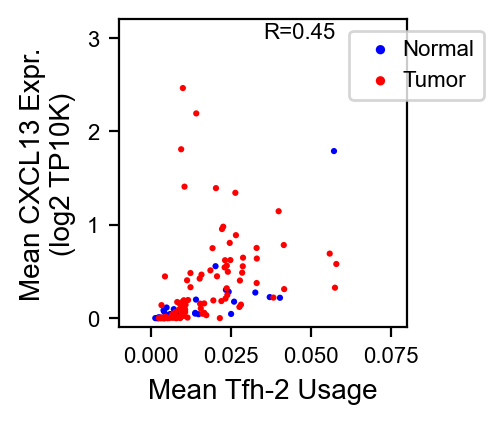

In [262]:
mean_tfh_usage = usage.groupby(meta[fixed_idv_col]).mean()['Tfh-2']
mean_cxcl3 = X.groupby(meta[fixed_idv_col]).mean()['CXCL13']

sampinfo = meta[[fixed_idv_col, 'cancerType', 'loc']].drop_duplicates()
sampinfo.index = sampinfo[fixed_idv_col]
sampinfo = sampinfo.loc[mean_cxcl3.index, :]

tumor_ind = sampinfo['loc'] == 'T'

R,P = pearsonr(mean_tfh_usage, mean_cxcl3)

(fig,ax) = plt.subplots(1, 1, figsize=(2,2), dpi=200, gridspec_kw={'left':.25, 'bottom':.2, 'top':.97, 'right':.97})
ax.scatter(mean_tfh_usage.loc[~tumor_ind], mean_cxcl3.loc[~tumor_ind], label='Normal', color='b', s=5, edgecolor='None')
ax.scatter(mean_tfh_usage.loc[tumor_ind], mean_cxcl3.loc[tumor_ind], label='Tumor', color='r', s=5, edgecolor='None')
ax.set_xlabel('Mean Tfh-2 Usage', fontsize=10)
ax.set_ylabel('Mean CXCL13 Expr.\n(log2 TP10K)', fontsize=10)
ax.tick_params(labelsize=8)
ax.set_ylim([-.1, 3.2])
ax.set_xlim([-.01, .08])
ax.legend(fontsize=8, markerscale=1.5, handletextpad=0, loc=(.8, .74))
ax.text(0.035, 3., 'R=%.2f' % R, fontsize=8)
#ax.text(0.035, 2.7, 'P=$4.1x10^{-19}$' % R, fontsize=8)

#plt.savefig(os.path.join(figdir, 'CancerAssociation.CXCL13.Corr.png'))
#plt.savefig(os.path.join(figdir, 'CancerAssociation.CXCL13.Corr.pdf'))

In [263]:
P

4.935264722289982e-08

Text(0.035, 3.0, 'R=0.66')

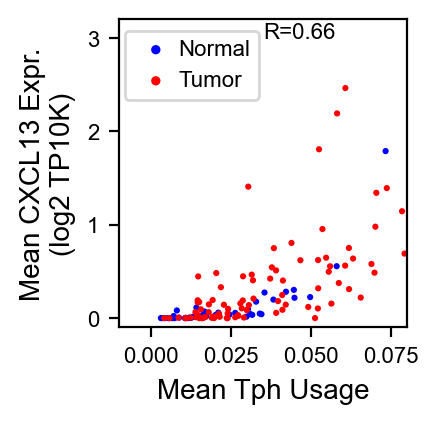

In [264]:
mean_tph_usage = usage[['Tph', 'Tfh-2']].sum(axis=1).groupby(meta[fixed_idv_col]).mean()
mean_cxcl3 = X.groupby(meta[fixed_idv_col]).mean()['CXCL13']

sampinfo = meta[[fixed_idv_col, 'cancerType', 'loc']].drop_duplicates()
sampinfo.index = sampinfo[fixed_idv_col]
sampinfo = sampinfo.loc[mean_cxcl3.index, :]

tumor_ind = sampinfo['loc'] == 'T'

R,P = pearsonr(mean_tph_usage, mean_cxcl3)

(fig,ax) = plt.subplots(1, 1, figsize=(2,2), dpi=200, gridspec_kw={'left':.25, 'bottom':.2, 'top':.97, 'right':.97})
ax.scatter(mean_tph_usage.loc[~tumor_ind], mean_cxcl3.loc[~tumor_ind], label='Normal', color='b', s=5, edgecolor='None')
ax.scatter(mean_tph_usage.loc[tumor_ind], mean_cxcl3.loc[tumor_ind], label='Tumor', color='r', s=5, edgecolor='None')
ax.set_xlabel('Mean Tph Usage', fontsize=10)
ax.set_ylabel('Mean CXCL13 Expr.\n(log2 TP10K)', fontsize=10)
ax.tick_params(labelsize=8)
ax.set_ylim([-.1, 3.2])
ax.set_xlim([-.01, .08])
ax.legend(fontsize=8, markerscale=1.5, handletextpad=0, loc=(.02, .74))
ax.text(0.035, 3., 'R=%.2f' % R, fontsize=8)
#ax.text(0.035, 2.7, 'P=$4.1x10^{-19}$' % R, fontsize=8)

In [265]:
P

3.5730375229812935e-18

Text(0.035, 3.0, 'R=0.13')

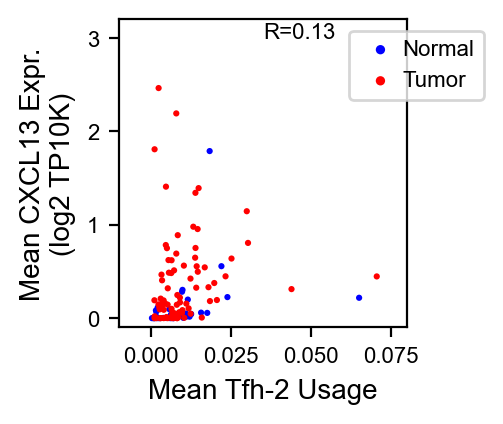

In [119]:
mean_tfh_usage = usage.groupby(meta[fixed_idv_col]).mean()['Tfh-1']
mean_cxcl3 = X.groupby(meta[fixed_idv_col]).mean()['CXCL13']

sampinfo = meta[[fixed_idv_col, 'cancerType', 'loc']].drop_duplicates()
sampinfo.index = sampinfo[fixed_idv_col]
sampinfo = sampinfo.loc[mean_cxcl3.index, :]

tumor_ind = sampinfo['loc'] == 'T'

R,P = pearsonr(mean_tfh_usage, mean_cxcl3)

(fig,ax) = plt.subplots(1, 1, figsize=(2,2), dpi=200, gridspec_kw={'left':.25, 'bottom':.2, 'top':.97, 'right':.97})
ax.scatter(mean_tfh_usage.loc[~tumor_ind], mean_cxcl3.loc[~tumor_ind], label='Normal', color='b', s=5, edgecolor='None')
ax.scatter(mean_tfh_usage.loc[tumor_ind], mean_cxcl3.loc[tumor_ind], label='Tumor', color='r', s=5, edgecolor='None')
ax.set_xlabel('Mean Tfh-2 Usage', fontsize=10)
ax.set_ylabel('Mean CXCL13 Expr.\n(log2 TP10K)', fontsize=10)
ax.tick_params(labelsize=8)
ax.set_ylim([-.1, 3.2])
ax.set_xlim([-.01, .08])
ax.legend(fontsize=8, markerscale=1.5, handletextpad=0, loc=(.8, .74))
ax.text(0.035, 3., 'R=%.2f' % R, fontsize=8)
#ax.text(0.035, 2.7, 'P=$4.1x10^{-19}$' % R, fontsize=8)

#plt.savefig(os.path.join(figdir, 'CancerAssociation.CXCL13.Corr.png'))
#plt.savefig(os.path.join(figdir, 'CancerAssociation.CXCL13.Corr.pdf'))

In [271]:
P

3.5730375229812935e-18

# Repeat per tumor types for cancers with sufficient samples

In [243]:
cell_counts = meta[sample_col].value_counts()
dd = meta[[fixed_idv_col, sample_col, 'loc', 'cancerType']].drop_duplicates()
dd.index = dd['sampleID']
dd['cell_counts'] = cell_counts.loc[dd.index]
ddfilt = dd.sort_values(by='cell_counts', ascending=False).drop_duplicates(subset='patient.uid.sampletype')
ddfilt = ddfilt.loc[ddfilt['cell_counts']>19, :]
ct = pd.crosstab(ddfilt['loc'], ddfilt['cancerType'])
hasenough = (ct>=2).sum(axis=0)
totest = hasenough.index[hasenough==2]
ct

cancerType,BC,BCC,BCL,ESCA,FTC,HCC,LUNG,MM,OV,PACA,RC,THCA,UCEC
loc,,,,,,,,,,,,,
N,2,0,0,6,0,5,3,0,1,1,9,8,8
T,2,11,2,7,1,5,1,3,1,21,10,10,9


In [244]:
hasenough

cancerType
BC      2
BCC     1
BCL     1
ESCA    2
FTC     0
HCC     2
LUNG    1
MM      1
OV      0
PACA    1
RC      2
THCA    2
UCEC    2
dtype: int64

In [245]:
for cancertype in totest:
    all_results[cancertype] = {}
    sample_data[cancertype] = {}
    ind = meta['cancerType']==cancertype
    meta_test = meta.loc[ind, :]
    usage_test = usage.loc[ind, :]
    
    if meta_test[ 'dataset.tech'].value_counts().shape[0] > 1:
        cat_covars = [ 'dataset.tech']
    else:
        cat_covars = []        
    
    for p in ['Cancer_Or_Not']:
        pc, cc, sample_level = test_association_unpaired(meta_test, usage_test, p,
                                            fixed_idv_col, cat_covar_cols=cat_covars, quant_covar_cols=q_covars,
                                            _min_cell_thresh=min_cells, method='OLS')

        all_results[cancertype][p] = pc
        sample_data[cancertype][p] = sample_level

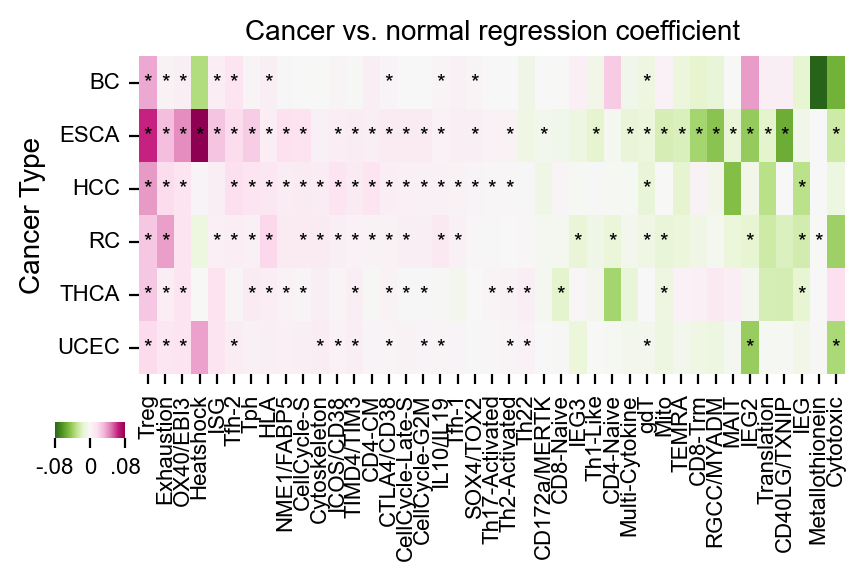

In [246]:
all_betas = []
all_Ps = []
for cancertype in totest:
    all_betas.append(all_results[cancertype]['Cancer_Or_Not']['Beta'])
    all_Ps.append(all_results[cancertype]['Cancer_Or_Not']['P'])

    
all_betas = pd.concat(all_betas, axis=1)
all_Ps = pd.concat(all_Ps, axis=1)

all_betas.columns = totest
all_Ps.columns = totest

order = all_betas.mean(axis=1).sort_values(ascending=False).index
all_betas = all_betas.loc[order, :]
all_Ps = all_Ps.loc[order, :]


all_Ps = all_Ps.T
all_betas = all_betas.T

todrop = [x for x in all_betas.columns if 'Doublet' in x] + list(all_Ps.columns[(all_Ps<.05).sum(axis=0)==0])
all_betas.drop(todrop, axis=1, inplace=True)
all_Ps.drop(todrop, axis=1, inplace=True)
all_Ps = all_Ps #.rename(columns=rename2)
all_betas = all_betas #.rename(columns=rename2)


(fig,ax) = plt.subplots(1,1, figsize=(4.3,3), dpi=200, gridspec_kw={'left':.15, 'bottom':.35, 'right':.97})
cax = ax.inset_axes([-0.12, -0.2, .1, 0.05], transform=ax.transAxes, zorder=-1)

sns.heatmap(all_betas, cmap='PiYG_r', #'bwr',
            vmin=-0.08, vmax=0.08, xticklabels=True, yticklabels=True, ax=ax,
           cbar_ax=cax, cbar_kws={'orientation':'horizontal', 'ticks':[-0.08, 0, 0.08]})



for j,gep in enumerate(all_Ps.columns):
    for i,cancertype in enumerate(all_Ps.index):
        if all_Ps.at[cancertype, gep] < .05:
            ax.text(j+.5, i+.5,  '*', ha='center', va='center', fontsize=8)
            
ax.set_ylabel('Cancer Type', fontsize=10)
ax.set_xlabel('', fontsize=10)
ax.set_title('Cancer vs. normal regression coefficient', fontsize=10)
_ = ax.set_xticklabels(all_betas.columns, fontsize=8)
_ = ax.set_yticklabels(all_betas.index, fontsize=8)

cax.tick_params(labelsize=8)
cax.set_xticklabels(['-.08', '0', '.08'])

plt.savefig(os.path.join(figdir, 'CancerAssociation.HeatmapAllCancers.png'))
plt.savefig(os.path.join(figdir, 'CancerAssociation.HeatmapAllCancers.pdf'))

In [247]:
from scipy.stats import fisher_exact

binarized = (all_betas.T>0).astype(int)
numsig = 0
numnotsig = 0
for i in range(binarized.shape[1]-1):
    for j in range(i+1, binarized.shape[1]):
        c1 = binarized.columns[i]
        c2 = binarized.columns[j]
        
        #ct = pd.crosstab(binarized[c1], binarized[c2]).loc[[0,1], [0,1]]
        p = binom.sf((binarized[c1] == binarized[c2]).sum(), binarized.shape[0], .5)
        print(c1, c2, p)
        if p < .05:
            numsig += 1
        else:
            numnotsig += 1

BC ESCA 0.0007252455070556607
BC HCC 0.013766577914793743
BC RC 0.0002154285211872775
BC THCA 0.26635462761805684
BC UCEC 0.0002154285211872775
ESCA HCC 5.129186320118606e-08
ESCA RC 3.9199221646413207e-10
ESCA THCA 0.002162002467230195
ESCA UCEC 3.9199221646413207e-10
HCC RC 3.920786184608005e-07
HCC THCA 0.005753894867666531
HCC UCEC 3.920786184608005e-07
RC THCA 0.0007252455070556607
RC UCEC 1.9099388737231493e-11
THCA UCEC 0.005753894867666531


In [249]:
((all_betas>0) & (all_Ps<.05)).sum(axis=0).sort_values(ascending=False)

GEP
Treg                6
CTLA4/CD38          6
Exhaustion          6
OX40/EBI3           5
IL10/IL19           5
Tfh-2               5
HLA                 5
TIMD4/TIM3          5
Th2-Activated       4
Tph                 4
CellCycle-G2M       4
CellCycle-S         4
ICOS/CD38           4
CellCycle-Late-S    4
Cytoskeleton        3
CD4-CM              3
NME1/FABP5          3
ISG                 3
SOX4/TOX2           3
Th22                2
Th17-Activated      2
Tfh-1               2
Heatshock           1
Metallothionein     0
IEG                 0
CD40LG/TXNIP        0
Translation         0
IEG2                0
MAIT                0
RGCC/MYADM          0
CD8-Trm             0
TEMRA               0
Mito                0
gdT                 0
Multi-Cytokine      0
CD4-Naive           0
Th1-Like            0
IEG3                0
CD8-Naive           0
CD172a/MERTK        0
Cytotoxic           0
dtype: int64

0.001443623987142928

30

In [179]:
binarized.shape

(42, 7)

In [155]:
all_betas.T.corr(method='spearman').unstack().sort_values(ascending=False).iloc[7:]

cancerType  cancerType
UCEC        ESCA          0.895795
ESCA        UCEC          0.895795
UCEC        HCC           0.829025
HCC         UCEC          0.829025
ESCA        HCC           0.805526
HCC         ESCA          0.805526
RC          HCC           0.759015
HCC         RC            0.759015
RC          UCEC          0.721741
UCEC        RC            0.721741
ESCA        RC            0.719796
RC          ESCA          0.719796
            THCA          0.439430
THCA        RC            0.439430
            HCC           0.431651
HCC         THCA          0.431651
THCA        UCEC          0.425654
UCEC        THCA          0.425654
THCA        ESCA          0.379629
ESCA        THCA          0.379629
BC          LUNG          0.365692
LUNG        BC            0.365692
BC          HCC           0.334414
HCC         BC            0.334414
RC          BC            0.277854
BC          RC            0.277854
            ESCA          0.273479
ESCA        BC            0.2734

In [158]:
all_betas.T.corr(method='spearman').unstack().sort_values(ascending=False).iloc[7:].median()

0.3656915971153067

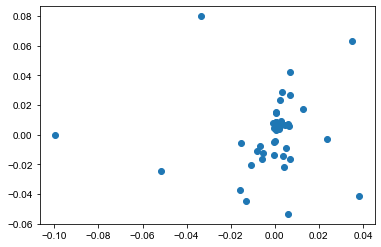

In [146]:
plt.scatter(all_betas.loc['BC', :], all_betas.loc['ESCA', :])

In [138]:
all_Ps['Th2-Activated']

cancerType
BC      0.428251
ESCA    0.023042
HCC     0.001900
LUNG    0.223919
RC      0.730901
THCA    0.000574
UCEC    0.022643
Name: Th2-Activated, dtype: float64

In [139]:
all_Ps['Th17-Activated']

cancerType
BC      0.491274
ESCA    0.127651
HCC     0.013131
LUNG    0.347014
RC      0.238635
THCA    0.000005
UCEC    0.110358
Name: Th17-Activated, dtype: float64

In [140]:
all_Ps.loc['THCA', 'Th17-Activated']

5.333864921314289e-06

In [108]:
((all_betas>0) & (all_Ps<.05)).sum(axis=0).sort_values(ascending=False)

GEP
Treg                7
Exhaustion          6
CTLA4/CD38          6
OX40/EBI3           5
Tfh-2               5
IL10/IL19           5
HLA                 5
TIMD4/TIM3          5
CD4-CM              4
CellCycle-G2M       4
CellCycle-Late-S    4
Th2-2               4
ICOS/CD38           4
CellCycle-S         4
Tph                 4
NME1/FABP5          3
ISG                 3
SOX4/TOX2           3
Cytoskeleton        3
CCR10-Migration     2
Tfh-1               2
Th17-2              2
CD4-Naive           1
IEG3                1
CD8-Naive           1
HeatShock           1
BCL2-Survival       0
IEG2                0
Metallothionein     0
IEG                 0
NK-like             0
CD8-EM              0
MAIT                0
CD40LG/TXNIP        0
Mito                0
RGCC/MYADM          0
CD8-Trm-Like        0
Th2-1               0
gdT-Blood           0
Multi-Cytokine      0
CD4-EM              0
Translation         0
MALAT1              0
Th17                0
TXNIP/H1FX          0
Cytoto

In [97]:
sample_data['LUNG']['Cancer_Or_Not'][['Cancer_Or_Not', 'Metallothionein', 'Treg']]

,Cancer_Or_Not,Metallothionein,Treg
patient.uid.sampletype,,,
NSCLC.QianqianSong2019.P1 - N,0.0,0.001122,0.009351
NSCLC.QianqianSong2019.P1 - T,1.0,0.000915,0.045176
NSCLC.QianqianSong2019.P2 - N,0.0,0.001129,0.027784
NSCLC.QianqianSong2019.P2 - T,1.0,0.000732,0.042275
NSCLC.QianqianSong2019.P3 - N,0.0,0.001456,0.003695
NSCLC.QianqianSong2019.P4 - N,0.0,0.001403,0.005725


In [98]:
all_results['LUNG']['Cancer_Or_Not'].sort_values(by='P')

,P,Beta,M0,M1,FC,log2_FC,Q,Pheno,logP,logQ
GEP,,,,,,,,,,
CD4-Naive,1.551641e-32,0.017883,0.019325,0.037207,1.925378,0.945142,8.068534e-31,Cancer_Or_Not,31.809209,30.093205
Treg,7.868776e-08,0.032087,0.011639,0.043725,3.756883,1.909536,2.045882e-06,Cancer_Or_Not,7.104093,5.689119
Metallothionein,2.137014e-04,-0.000454,0.001278,0.000823,0.644314,-0.634164,3.704158e-03,Cancer_Or_Not,3.670193,2.431311
CD4-CM,4.190349e-03,0.006684,0.007504,0.014188,1.890736,0.918948,5.357722e-02,Cancer_Or_Not,2.377750,1.271020
CD8-EM,5.151656e-03,-0.029873,0.039782,0.009909,0.249092,-2.005251,5.357722e-02,Cancer_Or_Not,2.288053,1.271020
Doublet-RBC,7.613169e-03,-0.000709,0.002166,0.001457,0.672649,-0.572075,6.598080e-02,Cancer_Or_Not,2.118435,1.180582
YPEL5/JUNB,1.093625e-02,0.021724,0.022870,0.044593,1.949895,0.963397,8.124073e-02,Cancer_Or_Not,1.961131,1.090226
Cytotoxic,2.578108e-02,-0.060556,0.068493,0.007938,0.115890,-3.109177,1.675770e-01,Cancer_Or_Not,1.588699,0.775785
CD8-Naive,4.165172e-02,0.008175,0.010601,0.018776,1.771215,0.824740,2.406544e-01,Cancer_Or_Not,1.380367,0.618606


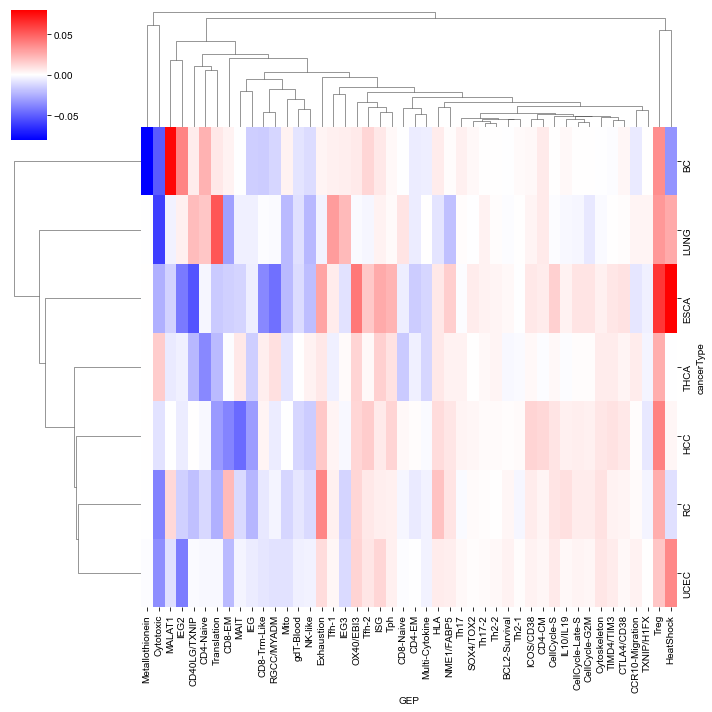

In [99]:
sns.clustermap(all_betas,  cmap='bwr', vmin=-0.08, vmax=0.08, xticklabels=True, yticklabels=True)

# Output supplementary table

In [76]:
outfn = '../../Tables/Table_S7_DiseaseAssociation.xlsx'

In [77]:
with pd.ExcelWriter(outfn) as writer:
    for dataset in all_results.keys():
        for pheno in all_results[dataset].keys():
            dat = all_results[dataset][pheno].sort_values(by='P', ascending=True)
            sheetname = dataset+ ' - ' + pheno
            dat.to_excel(writer, sheet_name=sheetname)
            
            
            for column in dat:
                column_length = max(dat[column].astype(str).map(len).max(), len(column))
                col_idx = dat.columns.get_loc(column)
                writer.sheets[sheetname].set_column(col_idx, col_idx, column_length)

# Covid-19 in CD4 EM and CM cells only (I.e. memory)

## COMBAT

In [55]:
dataset = 'COMBAT'
all_results_mem = {}
sample_data_mem = {}

all_results_mem[dataset] = {}
sample_data_mem[dataset] = {}
sample_col = params.loc[dataset, 'sample_col']
individual_col = params.loc[dataset, 'individual_col']
usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t').rename(columns=rename_map)
usage = usage.div(usage.sum(axis=1), axis=0)
meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], sep = '\t', index_col = 0)
meta = meta.loc[usage.index, :]
gating = pd.read_csv(params.loc[dataset,'manual_gating_fn'], sep='\t', index_col=0)['0']
meta['Gating'] = gating.loc[meta.index]

In [56]:
ind = meta['Gating'].isin(['CD4_EM', 'CD4_CM'])

In [57]:
meta = meta.loc[ind, :]
usage = usage.loc[meta.index, :]

In [58]:
meta[[individual_col, 'Source']].drop_duplicates()['Source'].value_counts()

COVID_SEV         32
Sepsis            23
COVID_CRIT        18
COVID_MILD        17
COVID_HCW_MILD    12
Flu               12
HV                10
COVID_LDN          2
Name: Source, dtype: int64

In [59]:
## For individuals with multiple samples, filter the sample with fewer cells
ct = pd.crosstab(meta[individual_col], meta[sample_col])
display((ct>0).sum(axis=1).value_counts())
ind = (ct>0).sum(axis=1)>1
ct = ct.loc[ind, :]
tokeep = ct.loc[:, (ct>0).sum(axis=0)>0].idxmax(axis=1)
tofilt = meta[individual_col].isin(tokeep.index) & ~meta[sample_col].isin(tokeep.values)
meta = meta.loc[~tofilt, :]
usage = usage.loc[~tofilt, :]
allmeta[dataset] = meta

ct = pd.crosstab(meta[individual_col], meta[sample_col])
(ct>0).sum(axis=1).value_counts()

1    109
2     10
3      3
dtype: int64

1    122
dtype: int64

In [60]:
meta[[individual_col, 'Source']].drop_duplicates()['Source'].value_counts()

COVID_SEV         29
Sepsis            23
COVID_CRIT        17
COVID_MILD        17
COVID_HCW_MILD    12
Flu               12
HV                10
COVID_LDN          2
Name: Source, dtype: int64

In [61]:
mapping = {'COVID_SEV':1, 'Sepsis':np.nan, 'COVID_MILD':1, 'COVID_HCW_MILD':1, 'HV':0,
       'COVID_CRIT':1, 'COVID_LDN':1, 'Flu':np.nan}

meta['COVID_vs_Healthy'] = meta['Source'].replace(mapping)

mapping = {'COVID_SEV':0, 'Sepsis':np.nan, 'COVID_MILD':0, 'COVID_HCW_MILD':0, 'HV':np.nan,
       'COVID_CRIT':1, 'COVID_LDN':1, 'Flu':np.nan}
meta['COVID_Severe_vs_Mild'] = meta['Source'].replace(mapping)


#meta['COVID_Severe_vs_Mild'] = np.nan
#ind = meta['COVID_vs_Healthy']==1
#{1:'Death', 2:'Intubated', 3:'NiV', 4:'O2', 5:'No O2', 6:'Not hospitalized'}
#meta.loc[ind, 'COVID_Severe_vs_Mild'] = meta.loc[ind, 'Outcome'].replace({1:1, 2:1, 3:0, 4:0, 5:0, 6:0})


In [62]:
 meta[['Source', individual_col]].drop_duplicates()['Source'].value_counts()

COVID_SEV         29
Sepsis            23
COVID_CRIT        17
COVID_MILD        17
COVID_HCW_MILD    12
Flu               12
HV                10
COVID_LDN          2
Name: Source, dtype: int64

In [63]:
pd.crosstab(meta['Source'], meta['Outcome'].replace(np.nan, 'null'))

Outcome,1.0,2.0,3.0,4.0,5.0,6.0,null
Source,,,,,,,
COVID_CRIT,2467,12741,0,0,0,0,0
COVID_HCW_MILD,0,0,0,0,0,20337,0
COVID_LDN,856,2101,0,0,0,0,0
COVID_MILD,0,0,0,3844,16251,0,0
COVID_SEV,3633,5902,11065,10097,0,0,0
Flu,654,2146,0,0,0,0,0
HV,0,0,0,0,0,15711,0
Sepsis,0,0,0,0,0,0,19553


In [64]:
meta['COVID_vs_Healthy'].value_counts()

1.0    89294
0.0    15711
Name: COVID_vs_Healthy, dtype: int64

In [65]:
meta['COVID_Severe_vs_Mild'].value_counts()

0.0    71129
1.0    18165
Name: COVID_Severe_vs_Mild, dtype: int64

In [66]:
cat_covars = ['Pool_ID', 'Institute']
#q_covars = ['QC_total_UMI']
q_covars = []


In [67]:
res = {}
for p in ['COVID_vs_Healthy', 'COVID_Severe_vs_Mild']:
    pc, cc, sample_level = test_association_unpaired(meta, usage, p,
                                            individual_col, cat_covar_cols=cat_covars, quant_covar_cols=q_covars,
                                            _min_cell_thresh=min_cells, method='OLS')

    all_results_mem[dataset][p] = pc
    sample_data_mem[dataset][p] = sample_level

In [68]:
all_results_mem['COMBAT']['COVID_vs_Healthy'].sort_values(by='P', ascending=True)

,P,Beta,M0,M1,FC,log2_FC,Q,Pheno,logP,logQ
GEP,,,,,,,,,,
Doublet-Plasmablast,7.187248e-28,-0.011625,0.039424,0.027427,0.695682,-0.523500,3.737369e-26,COVID_vs_Healthy,27.143437,25.427434
IEG2,2.874917e-21,0.018625,0.004081,0.022444,5.499101,2.459196,7.474784e-20,COVID_vs_Healthy,20.541375,19.126401
Doublet-Fibroblast,8.234551e-20,-0.002927,0.009525,0.006529,0.685488,-0.544796,1.427322e-18,COVID_vs_Healthy,19.084360,17.845478
YPEL5/JUNB,8.787314e-18,0.012764,0.007811,0.020406,2.612576,1.385473,1.142351e-16,COVID_vs_Healthy,17.056144,15.942201
BCL2-Survival,8.922015e-10,0.018209,0.025937,0.044995,1.734827,0.794792,9.278896e-09,COVID_vs_Healthy,9.049537,8.032504
CD40LG/TXNIP,2.629340e-09,0.023219,0.046219,0.069119,1.495470,0.580599,2.278762e-08,COVID_vs_Healthy,8.580153,7.642301
Tph,1.014261e-07,0.002959,0.005088,0.007994,1.571192,0.651860,7.534512e-07,COVID_vs_Healthy,6.993850,6.122945
Mito,2.676819e-07,-0.013206,0.020625,0.007168,0.347552,-1.524699,1.739932e-06,COVID_vs_Healthy,6.572381,5.759468
CellCycle-S,5.249618e-07,0.002689,0.001581,0.004183,2.646154,1.403897,3.033113e-06,COVID_vs_Healthy,6.279872,5.518111


## UK-Covid

In [69]:
dataset = 'UK-Covid'
all_results_mem[dataset] = {}
sample_data_mem[dataset] = {}
sample_col = params.loc[dataset, 'sample_col']
individual_col = params.loc[dataset, 'individual_col']
usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t').rename(columns=rename_map)
usage = usage.div(usage.sum(axis=1), axis=0)
meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], sep = '\t', index_col = 0)
gating = pd.read_csv(params.loc[dataset,'manual_gating_fn'], sep='\t', index_col=0)['0']
#meta['Gating'] = gating.loc[meta.index]

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


ValueError: Invalid file path or buffer object type: <class 'float'>

In [71]:
params.loc[dataset, :]

dataset                                                                 UK-Covid
usage_fn                       /data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...
gene_scores_fn                 /data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...
gene_tpm_fn                    /data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...
tcat_fn                        /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
tcat_fn_withsingletons         /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
manual_gating_fn                                                             NaN
manual_activation_gating_fn    /data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...
activation_score_fn            /data/srlab1/TCAT/Data/PerDataset/UKCOVID/Acti...
metadata_fn                    /data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...
Processing notebook path                                                     NaN
cNMF notebook path                                                           NaN
cluster_col                 

In [31]:
## For individuals with multiple samples, filter the sample with fewer cells
ct = pd.crosstab(meta[individual_col], meta[sample_col])
display((ct>0).sum(axis=1).value_counts())
ind = (ct>0).sum(axis=1)>1
ct = ct.loc[ind, :]
tokeep = ct.loc[:, (ct>0).sum(axis=0)>0].idxmax(axis=1)
tofilt = meta[individual_col].isin(tokeep.index) & ~meta[sample_col].isin(tokeep.values)
meta = meta.loc[~tofilt, :]
usage = usage.loc[~tofilt, :]
allmeta[dataset] = meta


ct = pd.crosstab(meta[individual_col], meta[sample_col])
(ct>0).sum(axis=1).value_counts()

1    109
2     12
dtype: int64

1    121
dtype: int64

In [32]:
pcol = 'Status_on_day_collection_summary'
mapping = {'Moderate':1, 'Healthy':0, 'Severe':1, 'Mild':1, 'Critical':1, 'Asymptomatic':np.nan, 'Non_covid':np.nan, 'LPS_90mins':np.nan, 'LPS_10hours':np.nan}
meta['COVID_vs_Healthy'] = meta[pcol].map(mapping)
pd.crosstab(meta[pcol].replace(np.nan, 'null'), meta['COVID_vs_Healthy'].replace(np.nan, 'null'))

COVID_vs_Healthy,0.0,1.0,null
Status_on_day_collection_summary,,,
Asymptomatic,0,0,14152
Critical,0,31002,0
Healthy,54232,0,0
LPS_10hours,0,0,1121
LPS_90mins,0,0,1436
Mild,0,56903,0
Moderate,0,70298,0
Non_covid,0,0,8425
Severe,0,27682,0


In [33]:
pcol = 'Status_on_day_collection_summary'
mapping = {'Moderate':0, 'Healthy':np.nan, 'Severe':0, 'Mild':0, 'Critical':1, 'Asymptomatic':np.nan, 'Non_covid':np.nan, 'LPS_90mins':np.nan, 'LPS_10hours':np.nan}
meta['COVID_Severe_vs_Mild'] = meta[pcol].map(mapping)
pd.crosstab(meta[pcol].replace(np.nan, 'null'), meta['COVID_Severe_vs_Mild'].replace(np.nan, 'null'))

COVID_Severe_vs_Mild,0.0,1.0,null
Status_on_day_collection_summary,,,
Asymptomatic,0,0,14152
Critical,0,31002,0
Healthy,0,0,54232
LPS_10hours,0,0,1121
LPS_90mins,0,0,1436
Mild,56903,0,0
Moderate,70298,0,0
Non_covid,0,0,8425
Severe,27682,0,0


In [34]:
meta['log_counts'] = meta['total_counts'].apply(np.log10)

In [35]:
meta.columns

Index(['sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts',
       'total_counts_mt', 'pct_counts_mt', 'full_clustering',
       'initial_clustering', 'Resample', 'Collection_Day', 'Sex',
       'Age_interval', 'Swab_result', 'Status', 'Smoker',
       'Status_on_day_collection', 'Status_on_day_collection_summary',
       'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status',
       'Outcome', 'patient_id', 'pct_mito', 'IEG_GEP_Score', 'n_counts',
       'FOS_expr', 'JUN_expr', 'JUNB_expr', 'ZFP36_expr', 'IEG_Usage',
       'RNA_Modality_Weight', 'leiden_WNN', 'full_clustering_reduced',
       'leiden_WNN_lab', 'leiden_WNN_lab_reduced', 'leiden',
       'COVID_vs_Healthy', 'COVID_Severe_vs_Mild', 'log_counts'],
      dtype='object')

In [36]:
cat_covars = ['Site']
#q_covars = ['total_counts']
q_covars = []

In [37]:
for p in ['COVID_vs_Healthy', 'COVID_Severe_vs_Mild']:
    pc, cc, sample_level = test_association_unpaired(meta, usage, p,
                                            individual_col, cat_covar_cols=cat_covars, quant_covar_cols=q_covars,
                                            _min_cell_thresh=min_cells, method='OLS')

    all_results[dataset][p] = pc
    sample_data[dataset][p] = sample_level

In [38]:
all_results['UK-Covid']['COVID_vs_Healthy'].loc['ISG', :]

P                       0.0
Beta               0.023576
M0                 0.006783
M1                 0.034569
FC                 5.096612
log2_FC            2.349538
Q                       0.0
Pheno      COVID_vs_Healthy
logP                7.40699
logQ               6.690987
Name: ISG, dtype: object

In [39]:
all_results['UK-Covid']['COVID_vs_Healthy'].loc['ISG', 'Q']

2.0371029152050814e-07

# Covid-19 in CD4 EM only (I.e. memory)

## COMBAT

In [96]:
dataset = 'COMBAT'
all_results_em = {}
sample_data_em = {}

all_results_em[dataset] = {}
sample_data_em[dataset] = {}
sample_col = params.loc[dataset, 'sample_col']
individual_col = params.loc[dataset, 'individual_col']
usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t').rename(columns=rename_map)
usage = usage.div(usage.sum(axis=1), axis=0)
meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], sep = '\t', index_col = 0)
meta = meta.loc[usage.index, :]
gating = pd.read_csv(params.loc[dataset,'manual_gating_fn'], sep='\t', index_col=0)['0']
meta['Gating'] = gating.loc[meta.index]

In [97]:
ind = meta['Gating'].isin(['CD4_EM'])

In [98]:
meta = meta.loc[ind, :]
usage = usage.loc[meta.index, :]

In [99]:
meta[[individual_col, 'Source']].drop_duplicates()['Source'].value_counts()

COVID_SEV         32
Sepsis            23
COVID_CRIT        18
COVID_MILD        17
COVID_HCW_MILD    12
Flu               12
HV                10
COVID_LDN          2
Name: Source, dtype: int64

In [100]:
## For individuals with multiple samples, filter the sample with fewer cells
ct = pd.crosstab(meta[individual_col], meta[sample_col])
display((ct>0).sum(axis=1).value_counts())
ind = (ct>0).sum(axis=1)>1
ct = ct.loc[ind, :]
tokeep = ct.loc[:, (ct>0).sum(axis=0)>0].idxmax(axis=1)
tofilt = meta[individual_col].isin(tokeep.index) & ~meta[sample_col].isin(tokeep.values)
meta = meta.loc[~tofilt, :]
usage = usage.loc[~tofilt, :]
allmeta[dataset] = meta

ct = pd.crosstab(meta[individual_col], meta[sample_col])
(ct>0).sum(axis=1).value_counts()

1    109
2     10
3      3
dtype: int64

1    122
dtype: int64

In [101]:
meta[[individual_col, 'Source']].drop_duplicates()['Source'].value_counts()

COVID_SEV         29
Sepsis            23
COVID_MILD        17
COVID_CRIT        17
COVID_HCW_MILD    12
Flu               12
HV                10
COVID_LDN          2
Name: Source, dtype: int64

In [102]:
mapping = {'COVID_SEV':1, 'Sepsis':np.nan, 'COVID_MILD':1, 'COVID_HCW_MILD':1, 'HV':0,
       'COVID_CRIT':1, 'COVID_LDN':1, 'Flu':np.nan}

meta['COVID_vs_Healthy'] = meta['Source'].replace(mapping)

mapping = {'COVID_SEV':0, 'Sepsis':np.nan, 'COVID_MILD':0, 'COVID_HCW_MILD':0, 'HV':np.nan,
       'COVID_CRIT':1, 'COVID_LDN':1, 'Flu':np.nan}
meta['COVID_Severe_vs_Mild'] = meta['Source'].replace(mapping)


#meta['COVID_Severe_vs_Mild'] = np.nan
#ind = meta['COVID_vs_Healthy']==1
#{1:'Death', 2:'Intubated', 3:'NiV', 4:'O2', 5:'No O2', 6:'Not hospitalized'}
#meta.loc[ind, 'COVID_Severe_vs_Mild'] = meta.loc[ind, 'Outcome'].replace({1:1, 2:1, 3:0, 4:0, 5:0, 6:0})


In [103]:
 meta[['Source', individual_col]].drop_duplicates()['Source'].value_counts()

COVID_SEV         29
Sepsis            23
COVID_MILD        17
COVID_CRIT        17
COVID_HCW_MILD    12
Flu               12
HV                10
COVID_LDN          2
Name: Source, dtype: int64

In [104]:
pd.crosstab(meta['Source'], meta['Outcome'].replace(np.nan, 'null'))

Outcome,1.0,2.0,3.0,4.0,5.0,6.0,null
Source,,,,,,,
COVID_CRIT,577,3379,0,0,0,0,0
COVID_HCW_MILD,0,0,0,0,0,6446,0
COVID_LDN,185,650,0,0,0,0,0
COVID_MILD,0,0,0,1130,4725,0,0
COVID_SEV,1004,1669,3163,2744,0,0,0
Flu,191,686,0,0,0,0,0
HV,0,0,0,0,0,5349,0
Sepsis,0,0,0,0,0,0,5605


In [105]:
meta['COVID_vs_Healthy'].value_counts()

1.0    25672
0.0     5349
Name: COVID_vs_Healthy, dtype: int64

In [106]:
meta['COVID_Severe_vs_Mild'].value_counts()

0.0    20881
1.0     4791
Name: COVID_Severe_vs_Mild, dtype: int64

In [107]:
cat_covars = ['Pool_ID', 'Institute']
#q_covars = ['QC_total_UMI']
q_covars = []


In [108]:
res = {}
for p in ['COVID_vs_Healthy', 'COVID_Severe_vs_Mild']:
    pc, cc, sample_level = test_association_unpaired(meta, usage, p,
                                            individual_col, cat_covar_cols=cat_covars, quant_covar_cols=q_covars,
                                            _min_cell_thresh=min_cells, method='OLS')

    all_results_em[dataset][p] = pc
    sample_data_em[dataset][p] = sample_level

In [109]:
all_results_em['COMBAT']['COVID_vs_Healthy'].sort_values(by='P', ascending=True)

,P,Beta,M0,M1,FC,log2_FC,Q,Pheno,logP,logQ
GEP,,,,,,,,,,
Doublet-Plasmablast,2.594460e-27,-0.011977,0.035672,0.023409,0.656220,-0.607748,1.349119e-25,COVID_vs_Healthy,26.585953,24.869950
Doublet-Fibroblast,4.241857e-20,-0.003347,0.009517,0.006087,0.639617,-0.644720,1.102883e-18,COVID_vs_Healthy,19.372444,17.957471
IEG2,9.525171e-19,0.021099,0.004244,0.024993,5.888484,2.557896,1.651030e-17,COVID_vs_Healthy,18.021127,16.782245
YPEL5/JUNB,1.839143e-17,0.011516,0.006545,0.017915,2.737337,1.452773,2.390886e-16,COVID_vs_Healthy,16.735384,15.621441
CD40LG/TXNIP,1.324153e-09,0.019731,0.043186,0.062674,1.451253,0.537299,1.377119e-08,COVID_vs_Healthy,8.878062,7.861029
Mito,2.476246e-09,-0.015570,0.022974,0.007233,0.314826,-1.667373,2.146080e-08,COVID_vs_Healthy,8.606206,7.668354
BCL2-Survival,2.145887e-08,0.014810,0.019747,0.035242,1.784621,0.835617,1.594087e-07,COVID_vs_Healthy,7.668393,6.797488
CD4-EM,1.106520e-07,-0.027331,0.074911,0.047662,0.636249,-0.652336,7.192378e-07,COVID_vs_Healthy,6.956041,6.143128
Tph,7.823287e-07,0.003655,0.006846,0.010461,1.528003,0.611647,4.520121e-06,COVID_vs_Healthy,6.106611,5.344850


# Covid-19 in CD4 EM and CM cells only (I.e. memory) filtering upregulated activation programs before normalizing

## COMBAT

In [230]:
dataset = 'COMBAT'
all_results_mem = {}
sample_data_mem = {}

all_results_mem[dataset] = {}
sample_data_mem[dataset] = {}
sample_col = params.loc[dataset, 'sample_col']
individual_col = params.loc[dataset, 'individual_col']
usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t').rename(columns=rename_map)

todrop = ['CellCycle-G2M', 'ISG',  'CellCycle-S', 
       'Early-Activation',  'CellCycle-Late-S',
       'Cytoskeleton', 'Metallothionein',  'IEG',  'IEG2',
       'TIMD4/TIM3-Activation', 'BCL2-Survival',
        'ICOS/CD38-Activation','CTLA4+/CD38+-Activation', 'OX40/EBI3-Activation', 'YPEL5/JUNB',
        'CD40LG/TXNIP', 'Tph', 'Exhaustion']

usage = usage.drop(todrop, axis=1)

usage = usage.div(usage.sum(axis=1), axis=0)
meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], sep = '\t', index_col = 0)
meta = meta.loc[usage.index, :]
gating = pd.read_csv(params.loc[dataset,'manual_gating_fn'], sep='\t', index_col=0)['0']
meta['Gating'] = gating.loc[meta.index]

In [231]:
ind = meta['Gating'].isin(['CD4_EM', 'CD4_CM'])

In [232]:
meta = meta.loc[ind, :]
usage = usage.loc[meta.index, :]

In [233]:
meta[[individual_col, 'Source']].drop_duplicates()['Source'].value_counts()

COVID_SEV         32
Sepsis            23
COVID_CRIT        18
COVID_MILD        17
COVID_HCW_MILD    12
Flu               12
HV                10
COVID_LDN          2
Name: Source, dtype: int64

In [234]:
## For individuals with multiple samples, filter the sample with fewer cells
ct = pd.crosstab(meta[individual_col], meta[sample_col])
display((ct>0).sum(axis=1).value_counts())
ind = (ct>0).sum(axis=1)>1
ct = ct.loc[ind, :]
tokeep = ct.loc[:, (ct>0).sum(axis=0)>0].idxmax(axis=1)
tofilt = meta[individual_col].isin(tokeep.index) & ~meta[sample_col].isin(tokeep.values)
meta = meta.loc[~tofilt, :]
usage = usage.loc[~tofilt, :]
allmeta[dataset] = meta

ct = pd.crosstab(meta[individual_col], meta[sample_col])
(ct>0).sum(axis=1).value_counts()

1    109
2     10
3      3
dtype: int64

1    122
dtype: int64

In [235]:
meta[[individual_col, 'Source']].drop_duplicates()['Source'].value_counts()

COVID_SEV         29
Sepsis            23
COVID_CRIT        17
COVID_MILD        17
COVID_HCW_MILD    12
Flu               12
HV                10
COVID_LDN          2
Name: Source, dtype: int64

In [236]:
mapping = {'COVID_SEV':1, 'Sepsis':np.nan, 'COVID_MILD':1, 'COVID_HCW_MILD':1, 'HV':0,
       'COVID_CRIT':1, 'COVID_LDN':1, 'Flu':np.nan}

meta['COVID_vs_Healthy'] = meta['Source'].replace(mapping)

mapping = {'COVID_SEV':0, 'Sepsis':np.nan, 'COVID_MILD':0, 'COVID_HCW_MILD':0, 'HV':np.nan,
       'COVID_CRIT':1, 'COVID_LDN':1, 'Flu':np.nan}
meta['COVID_Severe_vs_Mild'] = meta['Source'].replace(mapping)


#meta['COVID_Severe_vs_Mild'] = np.nan
#ind = meta['COVID_vs_Healthy']==1
#{1:'Death', 2:'Intubated', 3:'NiV', 4:'O2', 5:'No O2', 6:'Not hospitalized'}
#meta.loc[ind, 'COVID_Severe_vs_Mild'] = meta.loc[ind, 'Outcome'].replace({1:1, 2:1, 3:0, 4:0, 5:0, 6:0})


In [237]:
 meta[['Source', individual_col]].drop_duplicates()['Source'].value_counts()

COVID_SEV         29
Sepsis            23
COVID_CRIT        17
COVID_MILD        17
COVID_HCW_MILD    12
Flu               12
HV                10
COVID_LDN          2
Name: Source, dtype: int64

In [238]:
pd.crosstab(meta['Source'], meta['Outcome'].replace(np.nan, 'null'))

Outcome,1.0,2.0,3.0,4.0,5.0,6.0,null
Source,,,,,,,
COVID_CRIT,2467,12741,0,0,0,0,0
COVID_HCW_MILD,0,0,0,0,0,20337,0
COVID_LDN,856,2101,0,0,0,0,0
COVID_MILD,0,0,0,3844,16251,0,0
COVID_SEV,3633,5902,11065,10097,0,0,0
Flu,654,2146,0,0,0,0,0
HV,0,0,0,0,0,15711,0
Sepsis,0,0,0,0,0,0,19553


In [239]:
meta['COVID_vs_Healthy'].value_counts()

1.0    89294
0.0    15711
Name: COVID_vs_Healthy, dtype: int64

In [240]:
meta['COVID_Severe_vs_Mild'].value_counts()

0.0    71129
1.0    18165
Name: COVID_Severe_vs_Mild, dtype: int64

In [241]:
cat_covars = ['Pool_ID', 'Institute']
#q_covars = ['QC_total_UMI']
q_covars = []


In [242]:
res = {}
for p in ['COVID_vs_Healthy', 'COVID_Severe_vs_Mild']:
    pc, cc, sample_level = test_association_unpaired(meta, usage, p,
                                            individual_col, cat_covar_cols=cat_covars, quant_covar_cols=q_covars,
                                            _min_cell_thresh=min_cells, method='OLS')

    all_results_mem[dataset][p] = pc
    sample_data_mem[dataset][p] = sample_level

In [243]:
all_results_mem['COMBAT']['COVID_vs_Healthy'].sort_values(by='P', ascending=True)

,P,Beta,M0,M1,FC,log2_FC,Q,Pheno,logP,logQ
GEP,,,,,,,,,,
Doublet-Plasmablast,7.038016e-10,-0.007659,0.047622,0.039492,0.829270,-0.270086,2.392926e-08,COVID_vs_Healthy,9.152550,7.621071
Treg,9.886000e-07,0.013932,0.027197,0.040983,1.506885,0.591570,1.680620e-05,COVID_vs_Healthy,6.004979,4.774530
Doublet-Fibroblast,2.195444e-06,-0.002036,0.011438,0.009321,0.814926,-0.295260,2.149805e-05,COVID_vs_Healthy,5.658478,4.667601
Mito,2.529182e-06,-0.013824,0.024689,0.010517,0.425972,-1.231171,2.149805e-05,COVID_vs_Healthy,5.597020,4.667601
Doublet-Myeloid,9.999546e-06,0.008760,0.024778,0.032718,1.320480,0.401062,6.799691e-05,COVID_vs_Healthy,5.000020,4.167511
SOX4/TOX2,1.469509e-05,0.001589,0.007360,0.008908,1.210363,0.275440,8.327215e-05,COVID_vs_Healthy,4.832828,4.079500
HLA,8.054092e-05,0.003659,0.006963,0.010617,1.524803,0.608622,3.911987e-04,COVID_vs_Healthy,4.093983,3.407603
Doublet-RBC,5.543917e-04,0.000188,0.001450,0.001650,1.137530,0.185905,2.356165e-03,COVID_vs_Healthy,3.256183,2.627794
Th17,7.465027e-04,0.016941,0.054047,0.070992,1.313527,0.393446,2.820121e-03,COVID_vs_Healthy,3.126969,2.549732


# Compare Th1 marker abundances 

In [120]:
dataset = 'COMBAT'

In [113]:
adata = sc.read(params.loc[dataset, 'raw_counts_fn'])

Only considering the two last: ['.ADTfixed', '.h5ad'].
Only considering the two last: ['.ADTfixed', '.h5ad'].


In [121]:
gating = pd.read_csv(params.loc[dataset,'manual_gating_fn'], sep='\t', index_col=0)['0']


In [122]:
adata.obs['Gating'] = gating.loc[adata.obs.index]

In [146]:
mapping = {'COVID_SEV':1, 'Sepsis':np.nan, 'COVID_MILD':1, 'COVID_HCW_MILD':1, 'HV':0,
       'COVID_CRIT':1, 'COVID_LDN':1, 'Flu':np.nan}

adata.obs['COVID_vs_Healthy'] = adata.obs['Source'].replace(mapping)

In [147]:
adata_em = adata[adata.obs['Gating'].isin(['CD4_EM', 'CD4_CM']), :]

In [148]:
## For individuals with multiple samples, filter the sample with fewer cells
meta = adata_em.obs.copy()
ct = pd.crosstab(meta[individual_col], meta[sample_col])
display((ct>0).sum(axis=1).value_counts())
ind = (ct>0).sum(axis=1)>1
ct = ct.loc[ind, :]
tokeep = ct.loc[:, (ct>0).sum(axis=0)>0].idxmax(axis=1)
tofilt = meta[individual_col].isin(tokeep.index) & ~meta[sample_col].isin(tokeep.values)

1    109
2     10
3      3
dtype: int64

In [149]:
adata_em = adata_em[~tofilt, :]

In [170]:
rna_ind = adata_em.var['feature_types']=='Gene Expression'
adata_RNA = adata_em[:, rna_ind]
adata_ADT = adata_em[:, ~rna_ind]

In [171]:
sc.pp.normalize_per_cell(adata_RNA, counts_per_cell_after=1e4)
sc.pp.log1p(adata_RNA)

sc.pp.normalize_per_cell(adata_ADT, counts_per_cell_after=1e4)
sc.pp.log1p(adata_ADT)

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [191]:
rna_markers = ['CXCR3', 'IFNG', 'TBX21', 'CCR5', 'CCR4', 'CCR6', 'RORC', 'GATA3']
X = pd.DataFrame(adata_RNA[:, rna_markers].X.toarray(), index=adata_RNA.obs.index, columns=rna_markers)
adt_markers = ['AB_CXCR3','AB_CD194', 'AB_CD196']
Y = pd.DataFrame(adata_ADT[:, adt_markers].X.toarray(), index=adata_ADT.obs.index, columns=adt_markers)
X = pd.concat([X, Y], axis=1)

pseudobulk = X.groupby(adata_RNA.obs[individual_col]).mean()
pseudobulk_flat = pd.merge(left=pseudobulk.unstack().reset_index(),
                      right=adata_RNA.obs[['COVID_vs_Healthy', individual_col]].drop_duplicates(), 
                      on=individual_col, how='left')

In [194]:
pseudobulk_flat.columns = ['Gene', 'Sample', 'Expression', 'Phenotype']
pseudobulk_flat.head()

,Gene,Sample,Expression,Phenotype
0,CXCR3,G05061,0.129562,1.0
1,CXCR3,G05064,0.173402,1.0
2,CXCR3,G05073,0.172061,1.0
3,CXCR3,G05077,0.124153,1.0
4,CXCR3,G05078,0.129454,1.0


In [206]:
g = 'AB_CXCR3'
a = pseudobulk_flat.loc[(pseudobulk_flat['Gene'] == g) & (pseudobulk_flat['Phenotype'] == 1), 'Expression']
b = pseudobulk_flat.loc[(pseudobulk_flat['Gene'] == g) & (pseudobulk_flat['Phenotype'] == 0), 'Expression']
ttest_ind(a, b)

Ttest_indResult(statistic=-2.6231306463917092, pvalue=0.010325085124264988)

In [207]:
g = 'CXCR3'
a = pseudobulk_flat.loc[(pseudobulk_flat['Gene'] == g) & (pseudobulk_flat['Phenotype'] == 1), 'Expression']
b = pseudobulk_flat.loc[(pseudobulk_flat['Gene'] == g) & (pseudobulk_flat['Phenotype'] == 0), 'Expression']
ttest_ind(a, b)

Ttest_indResult(statistic=-5.325979226112789, pvalue=8.085361551599961e-07)

In [208]:
g = 'IFNG'
a = pseudobulk_flat.loc[(pseudobulk_flat['Gene'] == g) & (pseudobulk_flat['Phenotype'] == 1), 'Expression']
b = pseudobulk_flat.loc[(pseudobulk_flat['Gene'] == g) & (pseudobulk_flat['Phenotype'] == 0), 'Expression']
ttest_ind(a, b)

Ttest_indResult(statistic=1.060692866201049, pvalue=0.29183412941205933)

In [209]:
g = 'TBX21'
a = pseudobulk_flat.loc[(pseudobulk_flat['Gene'] == g) & (pseudobulk_flat['Phenotype'] == 1), 'Expression']
b = pseudobulk_flat.loc[(pseudobulk_flat['Gene'] == g) & (pseudobulk_flat['Phenotype'] == 0), 'Expression']
ttest_ind(a, b)

Ttest_indResult(statistic=-0.8572566227967109, pvalue=0.3937136588895971)

In [210]:
g = 'AB_CD196'
a = pseudobulk_flat.loc[(pseudobulk_flat['Gene'] == g) & (pseudobulk_flat['Phenotype'] == 1), 'Expression']
b = pseudobulk_flat.loc[(pseudobulk_flat['Gene'] == g) & (pseudobulk_flat['Phenotype'] == 0), 'Expression']
ttest_ind(a, b)

Ttest_indResult(statistic=-8.626260192763292, pvalue=3.0830496194984567e-13)

In [211]:
g = 'AB_CD194'
a = pseudobulk_flat.loc[(pseudobulk_flat['Gene'] == g) & (pseudobulk_flat['Phenotype'] == 1), 'Expression']
b = pseudobulk_flat.loc[(pseudobulk_flat['Gene'] == g) & (pseudobulk_flat['Phenotype'] == 0), 'Expression']
ttest_ind(a, b)

Ttest_indResult(statistic=-0.4346974553891168, pvalue=0.6648836546801189)

<AxesSubplot:xlabel='Gene', ylabel='Expression'>

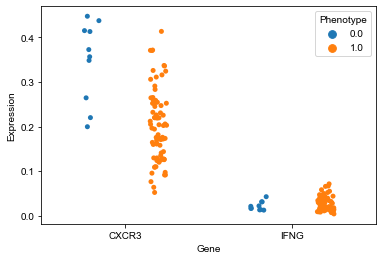

In [198]:
toplot = ['CXCR3', 'IFNG']
sns.stripplot(x='Gene', y='Expression', hue='Phenotype', dodge=True,
              data=pseudobulk_flat.loc[pseudobulk_flat['Gene'].isin(toplot), :])

<AxesSubplot:xlabel='Gene', ylabel='Expression'>

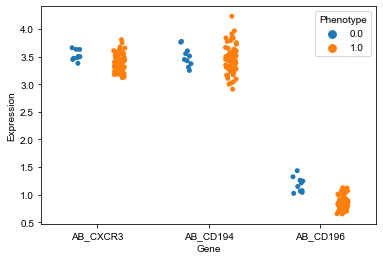

In [199]:
toplot = ['AB_CXCR3','AB_CD194', 'AB_CD196']
sns.stripplot(x='Gene', y='Expression', hue='Phenotype', dodge=True,
              data=pseudobulk_flat.loc[pseudobulk_flat['Gene'].isin(toplot), :])

<AxesSubplot:xlabel='Gene', ylabel='Expression'>

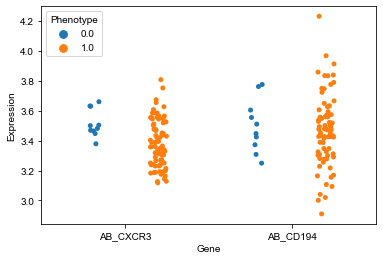

In [200]:
toplot = ['AB_CXCR3','AB_CD194']
sns.stripplot(x='Gene', y='Expression', hue='Phenotype', dodge=True,
              data=pseudobulk_flat.loc[pseudobulk_flat['Gene'].isin(toplot), :])

# CXCL13 by Tph abundance

# Covid-19 in monoyctes

In [65]:
dataset = 'COMBAT'
sample_col = params.loc[dataset, 'sample_col']
individual_col = params.loc[dataset, 'individual_col']
tcat_fn_pbmc = '/data/srlab1/TCAT/Data/PerDataset/COMBAT/TCAT_Usage.FullPBMC.20240209.tsv'
usage = pd.read_csv(tcat_fn_pbmc, index_col = 0, sep = '\t').rename(columns=rename_map)
usage = usage.div(usage.sum(axis=1), axis=0)
adata_fn = '/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.PBMC.Raw.h5ad'
adata = sc.read(adata_fn)
meta = adata.obs


Only considering the two last: ['.Raw', '.h5ad'].
Only considering the two last: ['.Raw', '.h5ad'].


In [66]:
## For individuals with multiple samples, filter the sample with fewer cells
ct = pd.crosstab(meta[individual_col], meta[sample_col])
display((ct>0).sum(axis=1).value_counts())
ind = (ct>0).sum(axis=1)>1
ct = ct.loc[ind, :]
tokeep = ct.loc[:, (ct>0).sum(axis=0)>0].idxmax(axis=1)
tofilt = meta[individual_col].isin(tokeep.index) & ~meta[sample_col].isin(tokeep.values)
meta = meta.loc[~tofilt, :]
usage = usage.loc[~tofilt, :]

ct = pd.crosstab(meta[individual_col], meta[sample_col])
(ct>0).sum(axis=1).value_counts()

1    111
2     10
3      3
dtype: int64

1    124
dtype: int64

In [67]:
mapping = {'COVID_SEV':1, 'Sepsis':np.nan, 'COVID_MILD':1, 'COVID_HCW_MILD':1, 'HV':0,
       'COVID_CRIT':1, 'COVID_LDN':1, 'Flu':np.nan}

meta['COVID_vs_Healthy'] = meta['Source'].replace(mapping)

mapping = {'COVID_SEV':0, 'Sepsis':np.nan, 'COVID_MILD':0, 'COVID_HCW_MILD':0, 'HV':np.nan,
       'COVID_CRIT':1, 'COVID_LDN':1, 'Flu':np.nan}
meta['COVID_Severe_vs_Mild'] = meta['Source'].replace(mapping)

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [68]:
cat_covars = ['Pool_ID', 'Institute']
#q_covars = ['QC_total_UMI']
q_covars = []


In [69]:
ind = meta['Annotation_major_subset'].isin(['cMono'])
meta_mono = meta.loc[ind,:].copy()
usage_mono = usage.loc[meta_mono.index, :].copy()

In [70]:



mono_res = {}
mono_sample_data = {}
mono_res[dataset] = {}
sample_data[dataset] = {}
for p in ['COVID_vs_Healthy', 'COVID_Severe_vs_Mild']:
    pc, cc, sample_level = test_association_unpaired(meta_mono, usage_mono, p,
                                            individual_col, cat_covar_cols=cat_covars, quant_covar_cols=q_covars,
                                            _min_cell_thresh=min_cells, method='OLS')

    all_results[dataset][p] = pc
    sample_data[dataset][p] = sample_level
    

In [72]:
all_results[dataset][p]

,P,Beta,M0,M1,FC,log2_FC,Q,Pheno,logP,logQ
GEP,,,,,,,,,,
CellCycle-G2M,6.828750e-04,0.002168,0.001955,0.003911,1.999972,0.999980,1.972750e-03,COVID_Severe_vs_Mild,3.165659,2.704928
Translation,1.833742e-02,-0.003303,0.005398,0.002718,0.503497,-0.989945,3.447427e-02,COVID_Severe_vs_Mild,1.736662,1.462505
HLA,8.515800e-10,-0.009365,0.013568,0.005039,0.371354,-1.429133,1.476072e-08,COVID_Severe_vs_Mild,9.069775,7.830892
ISG,6.826934e-01,-0.005661,0.045195,0.031719,0.701818,-0.510832,7.244910e-01,COVID_Severe_vs_Mild,0.165774,0.139967
Mito,1.439744e-01,0.003233,0.010213,0.013330,1.305216,0.384288,1.970176e-01,COVID_Severe_vs_Mild,0.841715,0.705495
Doublet-RBC,1.183167e-04,0.000246,0.001302,0.001505,1.155570,0.208605,5.127056e-04,COVID_Severe_vs_Mild,3.926954,3.290132
gdT-Blood,4.963474e-01,-0.000275,0.006914,0.006663,0.963700,-0.053344,5.610883e-01,COVID_Severe_vs_Mild,0.304214,0.250969
CellCycle-S,3.440944e-04,0.001724,0.003272,0.004891,1.494834,0.579985,1.192861e-03,COVID_Severe_vs_Mild,3.463322,2.923410
Cytotoxic,1.272242e-07,0.004236,0.020369,0.023768,1.166884,0.222661,1.323132e-06,COVID_Severe_vs_Mild,6.895430,5.878397


In [185]:
X.loc[Y['COMBAT_ID']=='U00701', :]

,CellCycle-G2M,Translation,HLA,ISG,Mito,Doublet-RBC,gdT-Blood,CellCycle-S,Cytotoxic,Doublet-Platelet,...,Tfh-2,OX40/EBI3-Activation,TXNIP/H1FX,YPEL5/JUNB,Doublet-Fibroblast,SOX4/TOX2,CD40LG/TXNIP,Tph,Exhaustion,Tfh-1


In [187]:
Y.loc[Y['COMBAT_ID']=='U00701', :]

,COVID_vs_Healthy,COMBAT_ID


In [148]:
usage_mono.shape

(192405, 52)

In [179]:
meta_mono.loc[meta_mono[individual_col]=='U00701', :]

,Annotation_cluster_id,Annotation_cluster_name,Annotation_minor_subset,Annotation_major_subset,Annotation_cell_type,GEX_region,QC_ngenes,QC_total_UMI,QC_pct_mitochondrial,QC_scrub_doublet_scores,...,SARSCoV2PCR,Outcome,TimeSinceOnset,Ethnicity,Tissue,DiseaseClassification,Pool_ID,Channel_ID,COVID_vs_Healthy,COVID_Severe_vs_Mild
AACCATGAGACTAGGC-1-gPlexD1,30100.0,cMono.LGALS2.AHNAK,cMono,cMono,MNP,C: Monocytes/cDC,616,1072,5.503731,0.085563,...,0,2.0,13.0,Unknown,Blood;UBERON:0000178,Influenza;MONDO:0005812,gPlexD,D1,NaN,NaN
ACTGAGTCAGGTGCCT-1-gPlexD1,30300.0,cMono.LGALS2.PSME2.IFITM3hi,cMono,cMono,MNP,C: Monocytes/cDC,1470,4327,3.351052,0.049195,...,0,2.0,13.0,Unknown,Blood;UBERON:0000178,Influenza;MONDO:0005812,gPlexD,D1,NaN,NaN
ATAAGAGGTAGAAGGA-1-gPlexD1,30300.0,cMono.LGALS2.PSME2.IFITM3hi,cMono,cMono,MNP,C: Monocytes/cDC,859,1998,3.253253,0.052783,...,0,2.0,13.0,Unknown,Blood;UBERON:0000178,Influenza;MONDO:0005812,gPlexD,D1,NaN,NaN
ATGCGATAGTAACCCT-1-gPlexD1,30000.0,cMono.S100A8/9/12hi.HMGB2,cMono,cMono,MNP,C: Monocytes/cDC,1104,3204,7.209738,0.076734,...,0,2.0,13.0,Unknown,Blood;UBERON:0000178,Influenza;MONDO:0005812,gPlexD,D1,NaN,NaN
CCTACACCAATAGCGG-1-gPlexD1,30000.0,cMono.S100A8/9/12hi.HMGB2,cMono,cMono,MNP,C: Monocytes/cDC,1578,5736,5.055788,0.046966,...,0,2.0,13.0,Unknown,Blood;UBERON:0000178,Influenza;MONDO:0005812,gPlexD,D1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCTATTGTCCAGAGGA-1-gPlexD7,30300.0,cMono.LGALS2.PSME2.IFITM3hi,cMono,cMono,MNP,C: Monocytes/cDC,684,1374,1.382824,0.043549,...,0,2.0,13.0,Unknown,Blood;UBERON:0000178,Influenza;MONDO:0005812,gPlexD,D7,NaN,NaN
TGAGCCGTCTCGCTTG-1-gPlexD7,30500.0,cMono.ribohi.TAGLN2,cMono,cMono,MNP,C: Monocytes/cDC,1719,6134,3.309423,0.050787,...,0,2.0,13.0,Unknown,Blood;UBERON:0000178,Influenza;MONDO:0005812,gPlexD,D7,NaN,NaN
TGGCCAGGTAACGTTC-1-gPlexD7,30300.0,cMono.LGALS2.PSME2.IFITM3hi,cMono,cMono,MNP,C: Monocytes/cDC,997,2749,1.236813,0.039100,...,0,2.0,13.0,Unknown,Blood;UBERON:0000178,Influenza;MONDO:0005812,gPlexD,D7,NaN,NaN
TGTTCCGTCCGCAGTG-1-gPlexD7,30500.0,cMono.ribohi.TAGLN2,cMono,cMono,MNP,C: Monocytes/cDC,702,1908,2.253669,0.026627,...,0,2.0,13.0,Unknown,Blood;UBERON:0000178,Influenza;MONDO:0005812,gPlexD,D7,NaN,NaN


# Cancer - combined samples

In [135]:
dataset = 'Pan-Cancer'
sample_col = params.loc[dataset, 'sample_col']
individual_col = params.loc[dataset, 'individual_col']
usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t').rename(columns=rename_map)
usage = usage.div(usage.sum(axis=1), axis=0)

meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], sep = '\t', index_col = 0)
meta = meta.loc[usage.index, :]

all_results[dataset] = {}
sample_data[dataset] = {}

In [136]:
sample_col

'sampleID'

In [137]:
dd = meta[[sample_col, individual_col, 'loc', 'cancerType']].drop_duplicates()
ct = pd.crosstab(dd['patient.uid'], dd['loc'])
ct

loc,N,T
patient.uid,,
BCC.KathrynEYost2019.su001,0,4
BCC.KathrynEYost2019.su002,0,2
BCC.KathrynEYost2019.su003,0,2
BCC.KathrynEYost2019.su004,0,3
BCC.KathrynEYost2019.su005,0,4
...,...,...
UCEC.thisStudy.UCEC.P20190312,1,1
UCEC.thisStudy.UCEC.P20190625,1,1
UCEC.thisStudy.UCEC.P20190717,1,1


In [138]:
ct.sort_values(by='T', ascending=False).head(10)

loc,N,T
patient.uid,,
BCC.KathrynEYost2019.su001,0,4
BCC.KathrynEYost2019.su005,0,4
RC.MatthewDYoung2018.RCC1,4,4
BCC.KathrynEYost2019.su008,0,4
RC.MatthewDYoung2018.RCC2,3,4
BCC.KathrynEYost2019.su004,0,3
BCC.KathrynEYost2019.su007,0,3
HCC.QimingZhang2019.10X.D20180108,1,2
BCC.KathrynEYost2019.su002,0,2


In [139]:
dd.loc[dd['patient.uid'] == 'RC.MatthewDYoung2018.RCC2', :]


,sampleID,patient.uid,loc,cancerType
4602STDY6976422___AACTCCCTCACTGGGC-22,4602STDY6976422,RC.MatthewDYoung2018.RCC2,T,RC
4602STDY6976423___AAACGGGCAGGCAGTA-22,4602STDY6976423,RC.MatthewDYoung2018.RCC2,T,RC
4602STDY6976424___AAACCTGGTAAACCTC-22,4602STDY6976424,RC.MatthewDYoung2018.RCC2,T,RC
4602STDY6976425___AAACGGGGTACATGTC-22,4602STDY6976425,RC.MatthewDYoung2018.RCC2,T,RC
4602STDY6976426___ACATACGTCATCACCC-22,4602STDY6976426,RC.MatthewDYoung2018.RCC2,N,RC
4602STDY6976427___AGCGTATCATTCGACA-22,4602STDY6976427,RC.MatthewDYoung2018.RCC2,N,RC
4602STDY6976428___ATTCTACCATCACGAT-22,4602STDY6976428,RC.MatthewDYoung2018.RCC2,N,RC


In [140]:
dd.loc[dd['patient.uid'] == 'BCC.KathrynEYost2019.su001', :]

,sampleID,patient.uid,loc,cancerType
bcc.su001.pre.tcell_AAACGGGTCATACGGT-0,bcc.su001.pre.tcell,BCC.KathrynEYost2019.su001,T,BCC
bcc.su001.pre_ACTATCTGTGCGATAG-0,bcc.su001.pre,BCC.KathrynEYost2019.su001,T,BCC
bcc.su001.post.tcell_AAACCTGCATTGCGGC-0,bcc.su001.post.tcell,BCC.KathrynEYost2019.su001,T,BCC
bcc.su001.post.tumor.cd45_AGCAGCCGTCTCACCT-0,bcc.su001.post.tumor.cd45,BCC.KathrynEYost2019.su001,T,BCC


In [141]:
pheno_cols = ['loc', 'cancerType']

In [142]:
meta['loc'].value_counts()

T    139379
N     75656
Name: loc, dtype: int64

In [143]:
pd.crosstab(meta['loc'], meta['cancerType'])

cancerType,BC,BCC,BCL,ESCA,FTC,HCC,LUNG,MM,OV,PACA,RC,THCA,UCEC
loc,,,,,,,,,,,,,
N,3206,0,0,9768,0,5067,1018,0,909,505,11762,28669,14752
T,4148,21011,3493,15114,1037,5897,187,8279,3613,10999,19414,28287,17900


In [144]:
individual_col

'patient.uid'

In [145]:
fixed_idv_col = 'patient.uid.sampletype'

In [146]:
meta['Cancer_Or_Not'] = meta['loc'].replace({'T':1.0, 'N':0.0})

In [153]:
meta[fixed_idv_col]= meta[individual_col] + ' - ' + meta['loc']

In [154]:
cat_covars = ['cancerType', 'dataset.tech']
#q_covars = ['n_counts']
q_covars = []

In [155]:
for p in ['Cancer_Or_Not']:
    pc, cc, sample_level = test_association_unpaired(meta, usage, p,
                                            fixed_idv_col, cat_covar_cols=cat_covars, quant_covar_cols=q_covars,
                                            _min_cell_thresh=min_cells, method='OLS')

    all_results[dataset][p] = pc
    sample_data[dataset][p] = sample_level

(-0.026307579353204512, 0.03519019217471454)

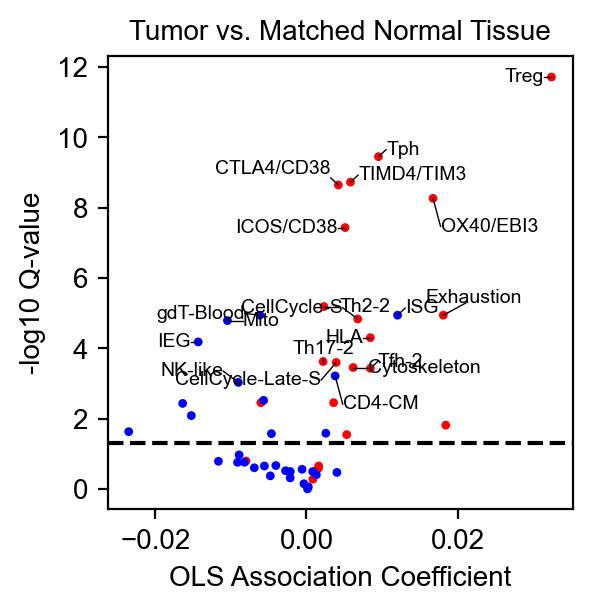

In [156]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)

dataset = 'Pan-Cancer'
p = 'Cancer_Or_Not'
dat = all_results[dataset][p]
xval = 'Beta'
yval = 'logQ'
fs = 7

ind = dat.index.isin(aim)

ax.scatter(dat.loc[ind, xval], dat.loc[ind, yval],
           s=10, edgecolor='None', color='r', label='AIM')

ax.scatter(dat.loc[~ind, xval], dat.loc[~ind, yval],
           s=10, edgecolor='None', color='b', label='Other')

ax.set_xlabel('OLS Association Coefficient', fontsize=10)
ax.set_ylabel('-log10 Q-value', fontsize=10)
ax.set_title('Tumor vs. Matched Normal Tissue', fontsize=10)

labthresh=3. #1*np.log10(.05)

for g in dat.index:
    if g in rename2.keys():
        lab = rename2[g]
    else:
        lab = g

    if (dat.at[g, yval]>labthresh) or (g == 'CTLA4+/CD38+-Activation'):
        
        if g == 'Doublet-Bcell':
            continue
        
        if g in ['Treg', 'Metallothionein',  'ICOS/CD38-Activation', 'HLA', 'CCR10-Migration', 'IEG', 'IL10/IL19-Secretion',]: deltax = -0.001; deltay =0; ha='right'; va='center' ## Left
        elif g in ['Tph',  'TIMD4/TIM3-Activation', 'ISG', 'Tfh-2']: deltax = 0.001; deltay = .2; ha='left'; va='center' ## Upper-right
        elif g in [ 'Exhaustion',]: deltax = 0.004; deltay = .5; ha='center'; va='center' ## Upper-right

        elif g in [ 'HLA']: deltax = 0.001; deltay = -.3; ha='left'; va='center' ## Lower-right
        elif g in [ 'OX40/EBI3-Activation', 'CD4-CM']: deltax = 0.001; deltay = -.8; ha='left'; va='center' ## Lower-right

        elif g in []: deltax = 0.001; deltay = 0; ha='left'; va='top' ## Lower-right 2
        elif g in ['Doublet-Plasmablast']: deltax = -0.001; deltay =-0.2; ha='right'; va='center' ## Lower-Left
        elif g in ['CellCycle-Late-S',]: deltax = -0.002; deltay =-0.5; ha='right'; va='center' ## Lower-Left 2

        elif g in [  'CellCycle-G2M', 'Th17-2']: deltax = 0; deltay =0.1; ha='center'; va='bottom' ## Above
        elif g in [ 'gdT-Blood',  ]: deltax = -0.002; deltay =0.05; ha='right'; va='center' ## Upper-Left
        elif g in [  'CellCycle-S', 'NK-like']: deltax = -0.002; deltay =0.32; ha='right'; va='center' ## Upper-Left

        elif g in ['CTLA4+/CD38+-Activation']: deltax = -0.001; deltay =0.2; ha='right'; va='bottom' ## Upper-Left 2
        else: deltax=.002; deltay=0; ha='left'; va='center' # Default to right

        if g not in ['Exhaustion']:
            ax.text(dat.at[g, xval]+deltax, dat.at[g, yval]+deltay, lab, ha=ha, va=va, fontsize=fs)
            ax.plot([dat.at[g, xval], dat.at[g, xval]+deltax], [dat.at[g, yval], dat.at[g, yval]+deltay], color='k', lw=.5)
        else:
            ax.text(dat.at[g, xval]+deltax, dat.at[g, yval]+deltay, lab, ha=ha, va=va, fontsize=fs)
            ax.plot([dat.at[g, xval], dat.at[g, xval]+deltax-.001], [dat.at[g, yval], dat.at[g, yval]+deltay-.15], color='k', lw=.5)





xlim = ax.get_xlim()
ax.hlines(y=np.log10(0.05)*-1, xmin=xlim[0], xmax=xlim[1], linestyle='--', color='k')
ax.set_xlim(xlim)

In [157]:
dat.sort_values(by='P')

,P,Beta,M0,M1,FC,log2_FC,Q,Pheno,logP,logQ
GEP,,,,,,,,,,
Treg,3.715828e-14,0.032395,0.016339,0.041322,2.529009,1.338572,1.932231e-12,Cancer_Or_Not,13.429944,11.713941
Tph,1.366193e-11,0.009521,0.010364,0.019743,1.905044,0.929824,3.552103e-10,Cancer_Or_Not,10.864488,9.449514
TIMD4/TIM3-Activation,1.086106e-10,0.005825,0.007501,0.013780,1.836923,0.877291,1.882583e-09,Cancer_Or_Not,9.964128,8.725246
CTLA4+/CD38+-Activation,1.741939e-10,0.004217,0.005785,0.009954,1.720689,0.782986,2.264521e-09,Cancer_Or_Not,9.758967,8.645024
OX40/EBI3-Activation,5.219862e-10,0.016738,0.006316,0.022615,3.580530,1.840173,5.428657e-09,Cancer_Or_Not,9.282341,8.265308
ICOS/CD38-Activation,4.243048e-09,0.005111,0.005975,0.010619,1.777234,0.829634,3.677308e-08,Cancer_Or_Not,8.372322,7.434470
Th2-2,8.721546e-07,0.002306,0.004994,0.008849,1.772151,0.825501,6.478863e-06,Cancer_Or_Not,6.059407,5.188501
ISG,1.952498e-06,0.012049,0.007826,0.018058,2.307300,1.206205,1.139859e-05,Cancer_Or_Not,5.709409,4.943149
gdT-Blood,2.148013e-06,-0.006167,0.019355,0.012628,0.652453,-0.616054,1.139859e-05,Cancer_Or_Not,5.667963,4.943149


# Cancer - separate samples

In [158]:
dataset = 'Pan-Cancer'
sample_col = params.loc[dataset, 'sample_col']
individual_col = params.loc[dataset, 'individual_col']
usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t').rename(columns=rename_map)
usage = usage.div(usage.sum(axis=1), axis=0)

meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], sep = '\t', index_col = 0)
meta = meta.loc[usage.index, :]

all_results[dataset] = {}
sample_data[dataset] = {}

In [159]:
sample_col

'sampleID'

In [160]:
dd = meta[[sample_col, individual_col, 'loc', 'cancerType']].drop_duplicates()
ct = pd.crosstab(dd['patient.uid'], dd['loc'])
ct

loc,N,T
patient.uid,,
BCC.KathrynEYost2019.su001,0,4
BCC.KathrynEYost2019.su002,0,2
BCC.KathrynEYost2019.su003,0,2
BCC.KathrynEYost2019.su004,0,3
BCC.KathrynEYost2019.su005,0,4
...,...,...
UCEC.thisStudy.UCEC.P20190312,1,1
UCEC.thisStudy.UCEC.P20190625,1,1
UCEC.thisStudy.UCEC.P20190717,1,1


In [161]:
ct.sort_values(by='T', ascending=False).head(10)

loc,N,T
patient.uid,,
BCC.KathrynEYost2019.su001,0,4
BCC.KathrynEYost2019.su005,0,4
RC.MatthewDYoung2018.RCC1,4,4
BCC.KathrynEYost2019.su008,0,4
RC.MatthewDYoung2018.RCC2,3,4
BCC.KathrynEYost2019.su004,0,3
BCC.KathrynEYost2019.su007,0,3
HCC.QimingZhang2019.10X.D20180108,1,2
BCC.KathrynEYost2019.su002,0,2


In [162]:
dd.loc[dd['patient.uid'] == 'RC.MatthewDYoung2018.RCC2', :]


,sampleID,patient.uid,loc,cancerType
4602STDY6976422___AACTCCCTCACTGGGC-22,4602STDY6976422,RC.MatthewDYoung2018.RCC2,T,RC
4602STDY6976423___AAACGGGCAGGCAGTA-22,4602STDY6976423,RC.MatthewDYoung2018.RCC2,T,RC
4602STDY6976424___AAACCTGGTAAACCTC-22,4602STDY6976424,RC.MatthewDYoung2018.RCC2,T,RC
4602STDY6976425___AAACGGGGTACATGTC-22,4602STDY6976425,RC.MatthewDYoung2018.RCC2,T,RC
4602STDY6976426___ACATACGTCATCACCC-22,4602STDY6976426,RC.MatthewDYoung2018.RCC2,N,RC
4602STDY6976427___AGCGTATCATTCGACA-22,4602STDY6976427,RC.MatthewDYoung2018.RCC2,N,RC
4602STDY6976428___ATTCTACCATCACGAT-22,4602STDY6976428,RC.MatthewDYoung2018.RCC2,N,RC


In [163]:
dd.loc[dd['patient.uid'] == 'BCC.KathrynEYost2019.su001', :]

,sampleID,patient.uid,loc,cancerType
bcc.su001.pre.tcell_AAACGGGTCATACGGT-0,bcc.su001.pre.tcell,BCC.KathrynEYost2019.su001,T,BCC
bcc.su001.pre_ACTATCTGTGCGATAG-0,bcc.su001.pre,BCC.KathrynEYost2019.su001,T,BCC
bcc.su001.post.tcell_AAACCTGCATTGCGGC-0,bcc.su001.post.tcell,BCC.KathrynEYost2019.su001,T,BCC
bcc.su001.post.tumor.cd45_AGCAGCCGTCTCACCT-0,bcc.su001.post.tumor.cd45,BCC.KathrynEYost2019.su001,T,BCC


In [164]:
pheno_cols = ['loc', 'cancerType']

In [165]:
meta['loc'].value_counts()

T    139379
N     75656
Name: loc, dtype: int64

In [166]:
pd.crosstab(meta['loc'], meta['cancerType'])

cancerType,BC,BCC,BCL,ESCA,FTC,HCC,LUNG,MM,OV,PACA,RC,THCA,UCEC
loc,,,,,,,,,,,,,
N,3206,0,0,9768,0,5067,1018,0,909,505,11762,28669,14752
T,4148,21011,3493,15114,1037,5897,187,8279,3613,10999,19414,28287,17900


In [167]:
meta['Cancer_Or_Not'] = meta['loc'].replace({'T':1.0, 'N':0.0})

In [168]:
cat_covars = ['cancerType', 'dataset.tech']
#q_covars = ['n_counts']
q_covars = []

In [169]:
for p in ['Cancer_Or_Not']:
    pc, cc, sample_level = test_association_unpaired(meta, usage, p,
                                            sample_col, cat_covar_cols=cat_covars, quant_covar_cols=q_covars,
                                            _min_cell_thresh=min_cells, method='OLS')

    all_results[dataset][p] = pc
    sample_data[dataset][p] = sample_level

(-0.03516306437404443, 0.03554950263281106)

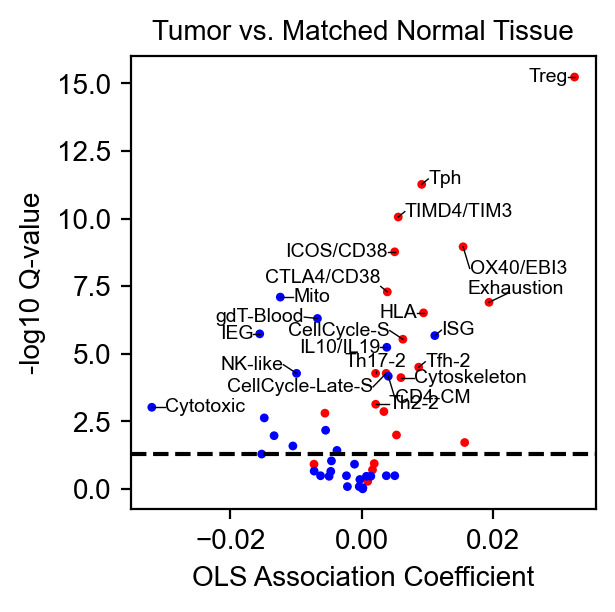

In [170]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)

dataset = 'Pan-Cancer'
p = 'Cancer_Or_Not'
dat = all_results[dataset][p]
xval = 'Beta'
yval = 'logQ'
fs = 7

ind = dat.index.isin(aim)

ax.scatter(dat.loc[ind, xval], dat.loc[ind, yval],
           s=10, edgecolor='None', color='r', label='AIM')

ax.scatter(dat.loc[~ind, xval], dat.loc[~ind, yval],
           s=10, edgecolor='None', color='b', label='Other')

ax.set_xlabel('OLS Association Coefficient', fontsize=10)
ax.set_ylabel('-log10 Q-value', fontsize=10)
ax.set_title('Tumor vs. Matched Normal Tissue', fontsize=10)

labthresh=3. #1*np.log10(.05)

for g in dat.index:
    if g in rename2.keys():
        lab = rename2[g]
    else:
        lab = g

    if (dat.at[g, yval]>labthresh) or (g == 'CTLA4+/CD38+-Activation'):
        
        if g == 'Doublet-Bcell':
            continue
        
        if g in ['Treg', 'Metallothionein',  'ICOS/CD38-Activation', 'HLA', 'CCR10-Migration', 'IEG', 'IL10/IL19-Secretion',]: deltax = -0.001; deltay =0; ha='right'; va='center' ## Left
        elif g in ['Tph',  'TIMD4/TIM3-Activation', 'ISG', 'Tfh-2']: deltax = 0.001; deltay = .2; ha='left'; va='center' ## Upper-right
        elif g in [ 'Exhaustion',]: deltax = 0.004; deltay = .5; ha='center'; va='center' ## Upper-right

        elif g in [ 'HLA']: deltax = 0.001; deltay = -.3; ha='left'; va='center' ## Lower-right
        elif g in [ 'OX40/EBI3-Activation', 'CD4-CM']: deltax = 0.001; deltay = -.8; ha='left'; va='center' ## Lower-right

        elif g in []: deltax = 0.001; deltay = 0; ha='left'; va='top' ## Lower-right 2
        elif g in ['Doublet-Plasmablast']: deltax = -0.001; deltay =-0.2; ha='right'; va='center' ## Lower-Left
        elif g in ['CellCycle-Late-S',]: deltax = -0.002; deltay =-0.5; ha='right'; va='center' ## Lower-Left 2

        elif g in [  'CellCycle-G2M', 'Th17-2']: deltax = 0; deltay =0.1; ha='center'; va='bottom' ## Above
        elif g in [ 'gdT-Blood',  ]: deltax = -0.002; deltay =0.05; ha='right'; va='center' ## Upper-Left
        elif g in [  'CellCycle-S', 'NK-like']: deltax = -0.002; deltay =0.32; ha='right'; va='center' ## Upper-Left

        elif g in ['CTLA4+/CD38+-Activation']: deltax = -0.001; deltay =0.2; ha='right'; va='bottom' ## Upper-Left 2
        else: deltax=.002; deltay=0; ha='left'; va='center' # Default to right

        if g not in ['Exhaustion']:
            ax.text(dat.at[g, xval]+deltax, dat.at[g, yval]+deltay, lab, ha=ha, va=va, fontsize=fs)
            ax.plot([dat.at[g, xval], dat.at[g, xval]+deltax], [dat.at[g, yval], dat.at[g, yval]+deltay], color='k', lw=.5)
        else:
            ax.text(dat.at[g, xval]+deltax, dat.at[g, yval]+deltay, lab, ha=ha, va=va, fontsize=fs)
            ax.plot([dat.at[g, xval], dat.at[g, xval]+deltax-.001], [dat.at[g, yval], dat.at[g, yval]+deltay-.15], color='k', lw=.5)





xlim = ax.get_xlim()
ax.hlines(y=np.log10(0.05)*-1, xmin=xlim[0], xmax=xlim[1], linestyle='--', color='k')
ax.set_xlim(xlim)

In [123]:
dat.sort_values(by='P')

,P,Beta,M0,M1,FC,log2_FC,Q,Pheno,logP,logQ
GEP,,,,,,,,,,
Treg,1.120234e-17,0.032335,0.015367,0.042383,2.758147,1.463699,5.825215e-16,Cancer_Or_Not,16.950691,15.234688
Tph,2.089275e-13,0.009092,0.009823,0.019584,1.993640,0.995405,5.432114e-12,Cancer_Or_Not,12.680004,11.265031
TIMD4/TIM3-Activation,5.056578e-12,0.005525,0.007173,0.012274,1.711117,0.774938,8.764735e-11,Cancer_Or_Not,11.296143,10.057261
OX40/EBI3-Activation,8.479616e-11,0.015386,0.005850,0.021403,3.658542,1.871269,1.102350e-09,Cancer_Or_Not,10.071624,8.957680
ICOS/CD38-Activation,1.631329e-10,0.004984,0.005670,0.010277,1.812513,0.857991,1.696582e-09,Cancer_Or_Not,9.787458,8.770425
CTLA4+/CD38+-Activation,5.922780e-09,0.003865,0.005643,0.010124,1.793994,0.843175,5.133076e-08,Cancer_Or_Not,8.227474,7.289622
Mito,1.078834e-08,-0.012413,0.025642,0.014840,0.578720,-0.789064,8.014197e-08,Cancer_Or_Not,7.967045,7.096140
Exhaustion,1.919888e-08,0.019331,0.010669,0.026119,2.448085,1.291654,1.247927e-07,Cancer_Or_Not,7.716724,6.903811
HLA,5.308100e-08,0.009368,0.008213,0.016667,2.029165,1.020886,3.066902e-07,Cancer_Or_Not,7.275061,6.513300


# Scratch